# Images analysis with Azure Document Intelligence and Azure OpenAI gpt-4o mini 

This notebook provides an example of how to use Azure AI Document Intelligence to output detected figures and the hierarchical document structure in markdown. 

It then crops the figures and sends their content, along with captions, to the Azure OpenAI GPT-4o mini model to interpret the semantics.

![Advanced document insights with figure understanding and hierarchical document structure](https://github.com/retkowsky/images/blob/master/adi_aoai.png?raw=true)

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0&tabs=sample-code

## 1. Settings

In [1]:
import base64
import fitz
import glob
import mimetypes
import openai
import os
import sys
import time

from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import ContentFormat
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

In [2]:
load_dotenv("azure.env")

# Azure OpenAI
AZURE_OPENAI_API_ENDPOINT: str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_MODEL_NAME: str = "gpt-4o-mini"
AZURE_OPENAI_API_VERSION: str = "2024-07-01-preview"

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

In [3]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0


In [4]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 2. Functions

In [5]:
def crop_image_from_image(image_file, page_number, bounding_box):
    """
    Crop a specified region from a specific page of an image file.

    Parameters:
    -----------
    image_file : str or file-like object
        The path to the image file or a file-like object containing the image.
        
    page_number : int
        The page number to crop from if the image file is multi-page (e.g., TIFF).
        
    bounding_box : tuple
        A tuple of four integers specifying the left, upper, right, and lower pixel
        coordinates (x1, y1, x2, y2) defining the region to crop.

    Returns:
    --------
    PIL.Image.Image
        A cropped image as a PIL Image object.
    """

    with Image.open(image_file) as img:
        if img.format == "TIFF":
            img.seek(page_number)
            img = img.copy()

        cropped_image = img.crop(bounding_box)

        return cropped_image

In [6]:
def crop_image_from_pdf_page(pdf_path, page_number, bounding_box):
    """
    Crops a region from a given page in a PDF and returns it as an image.

    :param pdf_path: Path to the PDF file.
    :param page_number: The page number to crop from (0-indexed).
    :param bounding_box: A tuple of (x0, y0, x1, y1) coordinates for the bounding box.
    :return: A PIL Image of the cropped area.
    """
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)
    
    # Cropping the page. The rect requires the coordinates in the format (x0, y0, x1, y1)
    bbx = [x * 72 for x in bounding_box]
    rect = fitz.Rect(bbx)
    pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72), clip=rect)
    
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    doc.close()

    return img

In [7]:
def crop_image_from_file(doc_file, page_number, bounding_box):
    """
    Crop a specified region from a specific page of a PDF file and return it as an image.

    Parameters:
    -----------
    pdf_file : str or file-like object
        The path to the PDF file or a file-like object containing the PDF.
        
    page_number : int
        The page number to crop from, with 0 being the first page.
        
    bounding_box : tuple
        A tuple of four floats specifying the left, upper, right, and lower coordinates
        (in inches) defining the region to crop.

    Returns:
    --------
    PIL.Image.Image
        A cropped image as a PIL Image object.
    """

    # Get mime type
    mime_type = mimetypes.guess_type(doc_file)[0]

    if mime_type == "application/pdf":
        return crop_image_from_pdf_page(doc_file, page_number, bounding_box)
    else:
        return crop_image_from_image(doc_file, page_number, bounding_box)

In [8]:
def local_image_to_data_url(image_path):
    """
    Convert a local image file to a data URL.

    Parameters:
    -----------
    image_path : str
        The path to the local image file to be converted.

    Returns:
    --------
    str
        A data URL representing the image, suitable for embedding in HTML or other web contexts.
    """
    # Get mime type
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = 'application/octet-stream'

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(
            image_file.read()).decode('utf-8')

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [9]:
def understand_image_with_gpt4o(AOAI_API_BASE, AOAI_API_KEY, AOAI_DEPLOYMENT_NAME,
                                AOAI_API_VERSION, image_path, caption):
    """
    Describe an image using GPT-4o from Azure OpenAI.

    Parameters:
    -----------
    api_base : str
        The base URL for the Azure OpenAI API.

    api_key : str
        The API key for authenticating with the Azure OpenAI service.

    deployment_name : str
        The name of the specific GPT-4 deployment to use.

    api_version : str
        The API version to use for the Azure OpenAI service.

    image_path : str
        The local path to the image file to be described.

    caption : str
        An optional caption to provide additional context for the image. 
        If not provided, only the image will be used for description.

    Returns:
    --------
    str
        A textual description of the image generated by GPT-4o.
    """

    # client
    client = AzureOpenAI(
        api_key=AOAI_API_KEY,
        api_version=AOAI_API_VERSION,
        base_url=f"{AOAI_API_BASE}/openai/deployments/{AOAI_DEPLOYMENT_NAME}")

    # data url
    data_url = local_image_to_data_url(image_path)

    if caption != "":
        response = client.chat.completions.create(
            model=AOAI_DEPLOYMENT_NAME,
            messages=[{
                "role": "system",
                "content": "You are an AI helpful assistant."
            }, {
                "role":
                "user",
                "content": [{
                    "type":
                    "text",
                    "text":
                    f"Describe this image (Note: it has image caption: {caption}):"
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": data_url
                    }
                }]
            }],
            max_tokens=800,
            temperature=0.7)

    else:
        response = client.chat.completions.create(
            model=AOAI_DEPLOYMENT_NAME,
            messages=[{
                "role": "system",
                "content": "You are an AI helpful assistant."
            }, {
                "role":
                "user",
                "content": [{
                    "type": "text",
                    "text": "Describe this image:"
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": data_url
                    }
                }]
            }],
            max_tokens=800,
            temperature=0.7)

    # result
    img_description = response.choices[0].message.content

    return img_description

In [10]:
def update_figure_description(md_content, img_description, idx):
    """
    Update the description of a figure in markdown content.

    This function finds a specific figure in the markdown content, identified by its index, 
    and inserts a new description as an HTML comment within the figure block.

    Parameters:
    -----------
    md_content : str
        The markdown content containing the figure.

    img_description : str
        The description to be added to the figure.

    idx : int or str
        The index of the figure to be updated, used in the image path pattern "figures/{idx}".

    Returns:
    --------
    str
        The updated markdown content with the new figure description inserted.
    """

    start_substring = f"![](figures/{idx})"
    end_substring = "</figure>"
    new_string = f"<!-- FigureContent=\"{img_description}\" -->"

    new_md_content = md_content
    start_index = md_content.find(start_substring)
    
    if start_index != -1:  # if start_substring is found
        start_index += len(
            start_substring)  # move the index to the end of start_substring
        end_index = md_content.find(end_substring, start_index)
    
        if end_index != -1:  # if end_substring is found
            # Replace the old string with the new string
            new_md_content = md_content[:start_index] + new_string + md_content[
                end_index:]

    return new_md_content

In [11]:
def analyze_layout(input_file_path, output_folder):
    """
    Analyze the layout of a document, extract figures, crop images, and update figure descriptions.

    This function uses Azure's Document Intelligence service to analyze the layout of a document, 
    identify figures, and process them by cropping the images and generating descriptions using GPT-4. 
    The updated markdown content with figure descriptions is returned.

    Parameters:
    -----------
    input_file_path : str
        The path to the input document file to be analyzed.

    output_folder : str
        The folder where cropped figure images will be saved.

    Returns:
    --------
    str
        The updated markdown content with the new figure descriptions inserted.
    """
    # Azure Document Intelligence client
    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,
        credential=AzureKeyCredential(AZURE_DOCUMENT_INTELLIGENCE_KEY),
        headers={"x-ms-useragent": "sample-code-figure-understanding/1.0.0"},
    )

    # Opening the file
    with open(input_file_path, "rb") as f:
        poller = document_intelligence_client.begin_analyze_document(
            "prebuilt-layout",
            analyze_request=f,
            content_type="application/octet-stream",
            output_content_format=ContentFormat.MARKDOWN)

    # Polling results
    result = poller.result()
    md_content = result.content

    # If images
    if result.figures:
        print("***** Images analysis *****")
        
        for idx, figure in enumerate(result.figures):
            figure_content = ""
            img_description = ""
            
            print(f"Figure #{idx} has the following spans: {figure.spans}")
            print()
            
            for i, span in enumerate(figure.spans):
                print(f"Span #{i}: {span}")
                figure_content += md_content[span.offset:span.offset +
                                             span.length]
            print(f"Original figure content in markdown: {figure_content}")

            if figure.caption:
                caption_region = figure.caption.bounding_regions
                print(f"- Caption: {figure.caption.content}")
                print(f"- Caption bounding region: {caption_region}")
                
                for region in figure.bounding_regions:
                    if region not in caption_region:
                        print(f"- Figure body bounding regions: {region}")

                        boundingbox = (
                            region.polygon[0],
                            region.polygon[1],
                            region.polygon[4],
                            region.polygon[5]
                        )
                        print(f"- Figure body bounding box in (x0, y0, x1, y1): {boundingbox}")
                        cropped_image = crop_image_from_file(
                            input_file_path, region.page_number - 1,
                            boundingbox)  # page_number is 1-indexed

                        base_name = os.path.basename(input_file_path)
                        file_name_without_extension = os.path.splitext(base_name)[0]

                        output_file = f"{file_name_without_extension}_cropped_image_{idx}.png"
                        cropped_image_filename = os.path.join(output_folder, output_file)

                        cropped_image.save(cropped_image_filename)
                        print(f"- Figure {idx} cropped and saved: {cropped_image_filename}")
                        img_description += understand_image_with_gpt4o(
                            AZURE_OPENAI_API_ENDPOINT, AZURE_OPENAI_API_KEY, AZURE_OPENAI_MODEL_NAME,
                            AZURE_OPENAI_API_VERSION, cropped_image_filename,
                            figure.caption.content)
                        print(f"- Description of figure {idx}: {img_description}")
                        print()
                        print()
                        print("*" * 120)
                        print()

            else:
                print("- No caption found for this figure.")
                for region in figure.bounding_regions:
                    
                    print(f"- Figure body bounding regions: {region}")
                    
                    boundingbox = (
                        region.polygon[0],  # x0 (left)
                        region.polygon[1],  # y0 (top
                        region.polygon[4],  # x1 (right)
                        region.polygon[5]  # y1 (bottom)
                    )
                    
                    print(f"- Figure body bounding box in (x0, y0, x1, y1): {boundingbox}")

                    cropped_image = crop_image_from_file(
                        input_file_path, region.page_number - 1,
                        boundingbox)  # page_number is 1-indexed

                    base_name = os.path.basename(input_file_path)
                    file_name_without_extension = os.path.splitext(
                        base_name)[0]

                    # Saving image
                    output_file = f"{file_name_without_extension}_cropped_image_{idx}.png"
                    cropped_image_filename = os.path.join(output_folder, output_file)
                    cropped_image.save(cropped_image_filename)
                    
                    print(f"- Figure {idx} cropped and saved as {cropped_image_filename}")
                    
                    img_description += understand_image_with_gpt4o(
                        AZURE_OPENAI_API_ENDPOINT, AZURE_OPENAI_API_KEY, AZURE_OPENAI_MODEL_NAME,
                        AZURE_OPENAI_API_VERSION, cropped_image_filename, "")
                    
                    print(f"- Description of figure {idx}: {img_description}\n\n")
                    print("*" * 120, "\n")

            md_content = update_figure_description(md_content, img_description, idx)

    return md_content

## 3. Tests



In [12]:
OUTPUT_DIR = "extracted_images"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [13]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [14]:
# Downloading a sample PDF file
doc_file = os.path.join(DOCS_DIR, "architecture.pdf")

!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/MSFT_cloud_architecture_contoso.pdf -O $doc_file

--2024-09-06 14:46:39--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/MSFT_cloud_architecture_contoso.pdf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/MSFT_cloud_architecture_contoso.pdf [following]
--2024-09-06 14:46:40--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/MSFT_cloud_architecture_contoso.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1848242 (1.8M) [application/octet-stream]
Saving to: ‘documents/architecture.pdf’

documents/architect 100%[===================>]   1.76M  --.-KB/s

In [15]:
!ls $doc_file -lh

-rwxrwxrwx 1 root root 1.8M Sep  6 14:46 documents/architecture.pdf


### Analysis of all the images from the PDF document

In [16]:
start = time.time()

results_md = analyze_layout(doc_file, OUTPUT_DIR)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

***** Images analysis *****
Figure #0 has the following spans: [{'offset': 465, 'length': 445}]

Span #0: {'offset': 465, 'length': 445}
Original figure content in markdown: 
<figure>

![](figures/0)

<!-- FigureContent="Toronto Edinburgh Novosibirsk Detroit Montreal Cologne Chicago Boston Minneapolis Tokyo Moscow Dublin Beijing Silicon Valley Thames Valley Munich Los Angeles St. Louis New York Paris Irvine O Philadelphia Dubai Mumbai Dallas Reston Milan Charlotte Taipei Tel Aviv Atlanta Guangzhou Mexico City Houston Bangalore Headquarters Sao Paulo Singapore Regional Hub Johannesburg Satellite" -->

</figure>


- No caption found for this figure.
- Figure body bounding regions: {'pageNumber': 1, 'polygon': [0.5756, 5.1778, 10.481, 5.1691, 10.4836, 10.0215, 0.5799, 10.0288]}
- Figure body bounding box in (x0, y0, x1, y1): (0.5756, 5.1778, 10.4836, 10.0215)
- Figure 0 cropped and saved as extracted_images/architecture_cropped_image_0.png
- Description of figure 0: The image is a world m

- Figure 7 cropped and saved as extracted_images/architecture_cropped_image_7.png
- Description of figure 7: The image presents a structured overview of three cloud service models: Software as a Service (SaaS), Platform as a Service (PaaS), and Infrastructure as a Service (IaaS). 

- **SaaS** is highlighted in orange, featuring applications like Office 365, Dynamics 365, and Intune/EMS, which focus on productivity, customer management, and device management, respectively.
  
- **PaaS** is shown in green, emphasizing the hosting of sales and support systems and the development of mobile applications using cloud resources.

- **IaaS** is outlined in blue, detailing services that enable the migration of legacy systems and data management, including the use of temporary servers for processing needs.

Each category lists specific services along with numbered circles, possibly indicating priority or steps related to each service.


************************************************************

- Description of figure 14: The image features a stylized design consisting of a cloud shape and various geometric elements. To the left, there is a triangular shape with a smaller triangle inside it, suggesting a design or icon-like appearance. In the center, there is a rectangular shape that appears to represent a building or structure, with a door and window indicated. The overall color scheme is simple, using shades of gray. The composition gives off a modern and minimalistic vibe.


************************************************************************************************************************ 

Figure #15 has the following spans: [{'offset': 16036, 'length': 75}]

Span #0: {'offset': 16036, 'length': 75}
Original figure content in markdown: n to a Microsoft peering location that connects your network to the Microso
- No caption found for this figure.
- Figure body bounding regions: {'pageNumber': 4, 'polygon': [9.3215, 16.2946, 10.4883, 16.2949, 10.488, 16.5705, 9.3209, 1

- Figure 20 cropped and saved as extracted_images/architecture_cropped_image_20.png
- Description of figure 20: The image depicts a network architecture involving a client computer, multiple regional offices, and a DMZ (Demilitarized Zone) for handling authentication requests.

1. **Client Computer**: At the top, there’s an icon representing a client computer that initiates requests.

2. **Traffic Manager**: Below the client, a traffic manager icon is shown, which likely directs traffic to different regional offices.

3. **Regional Offices**: There are three regional offices, each with authentication servers. These offices are connected to a central regional office.

4. **DMZ**: The DMZ contains AD FS (Active Directory Federation Services) servers and web application proxies. It handles authentication requests coming from the client.

5. **Windows Server AD Domain Controllers**: Within the regional office, there are Windows Server AD domain controllers that manage user authentication a

- Description of figure 25: The image features the Microsoft logo, which consists of four colored squares arranged in a 2x2 grid. The top left square is orange, the top right is green, the bottom left is blue, and the bottom right is yellow. To the right of the squares, the word "Microsoft" is displayed in a simple, gray font. The overall design conveys a modern and clean aesthetic.


************************************************************************************************************************ 

Figure #26 has the following spans: [{'offset': 34570, 'length': 75}]

Span #0: {'offset': 34570, 'length': 75}
Original figure content in markdown: ure." --></figure>



## Organization The Contoso Corporation is identified
- No caption found for this figure.
- Figure body bounding regions: {'pageNumber': 9, 'polygon': [9.3437, 16.0773, 10.5895, 16.0777, 10.5893, 16.3617, 9.3433, 16.3614]}
- Figure body bounding box in (x0, y0, x1, y1): (9.3437, 16.0773, 10.5893, 16.3617)
- Figure 26

### Displaying all the extracted images from the PDF file

In [35]:
for idx, imgfile in enumerate(glob.glob(OUTPUT_DIR + "/*.png"), start=1):
    print(f"{idx:3}\t {imgfile}")

  1	 extracted_images/architecture_cropped_image_0.png
  2	 extracted_images/architecture_cropped_image_1.png
  3	 extracted_images/architecture_cropped_image_10.png
  4	 extracted_images/architecture_cropped_image_11.png
  5	 extracted_images/architecture_cropped_image_12.png
  6	 extracted_images/architecture_cropped_image_13.png
  7	 extracted_images/architecture_cropped_image_14.png
  8	 extracted_images/architecture_cropped_image_15.png
  9	 extracted_images/architecture_cropped_image_16.png
 10	 extracted_images/architecture_cropped_image_17.png
 11	 extracted_images/architecture_cropped_image_18.png
 12	 extracted_images/architecture_cropped_image_19.png
 13	 extracted_images/architecture_cropped_image_2.png
 14	 extracted_images/architecture_cropped_image_20.png
 15	 extracted_images/architecture_cropped_image_21.png
 16	 extracted_images/architecture_cropped_image_22.png
 17	 extracted_images/architecture_cropped_image_23.png
 18	 extracted_images/architecture_cropped_image_24

Extracted images from documents/architecture.pdf

******************** Image 1: extracted_images/architecture_cropped_image_0.png ********************



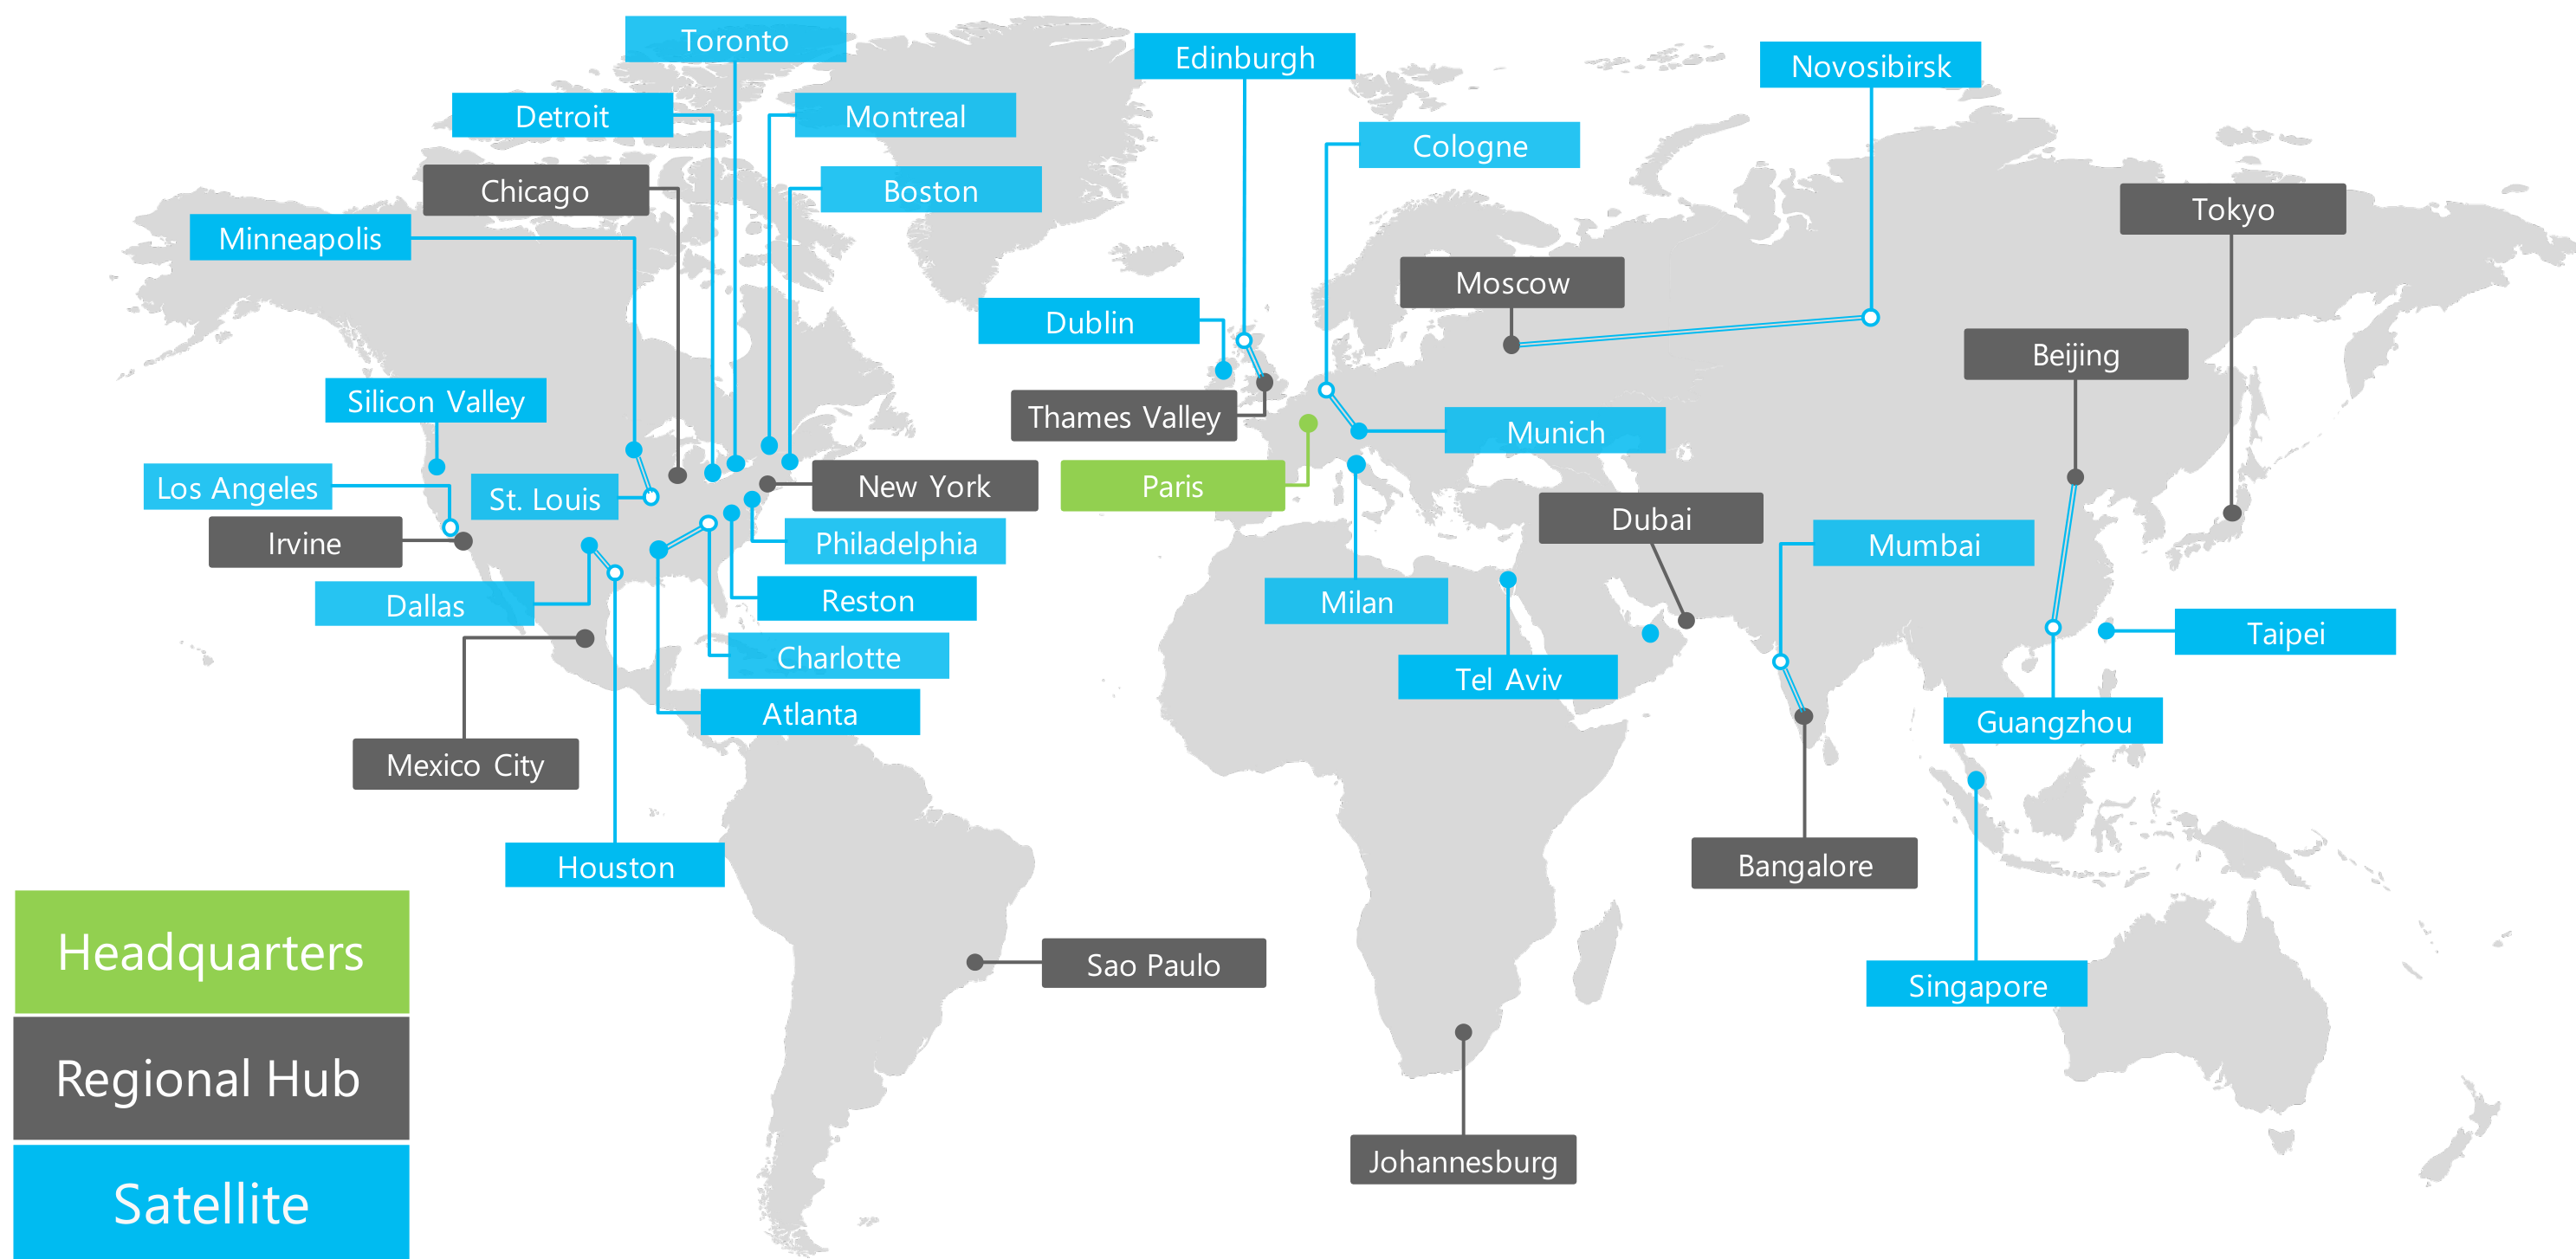


******************** Image 2: extracted_images/architecture_cropped_image_1.png ********************



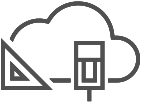


******************** Image 3: extracted_images/architecture_cropped_image_10.png ********************



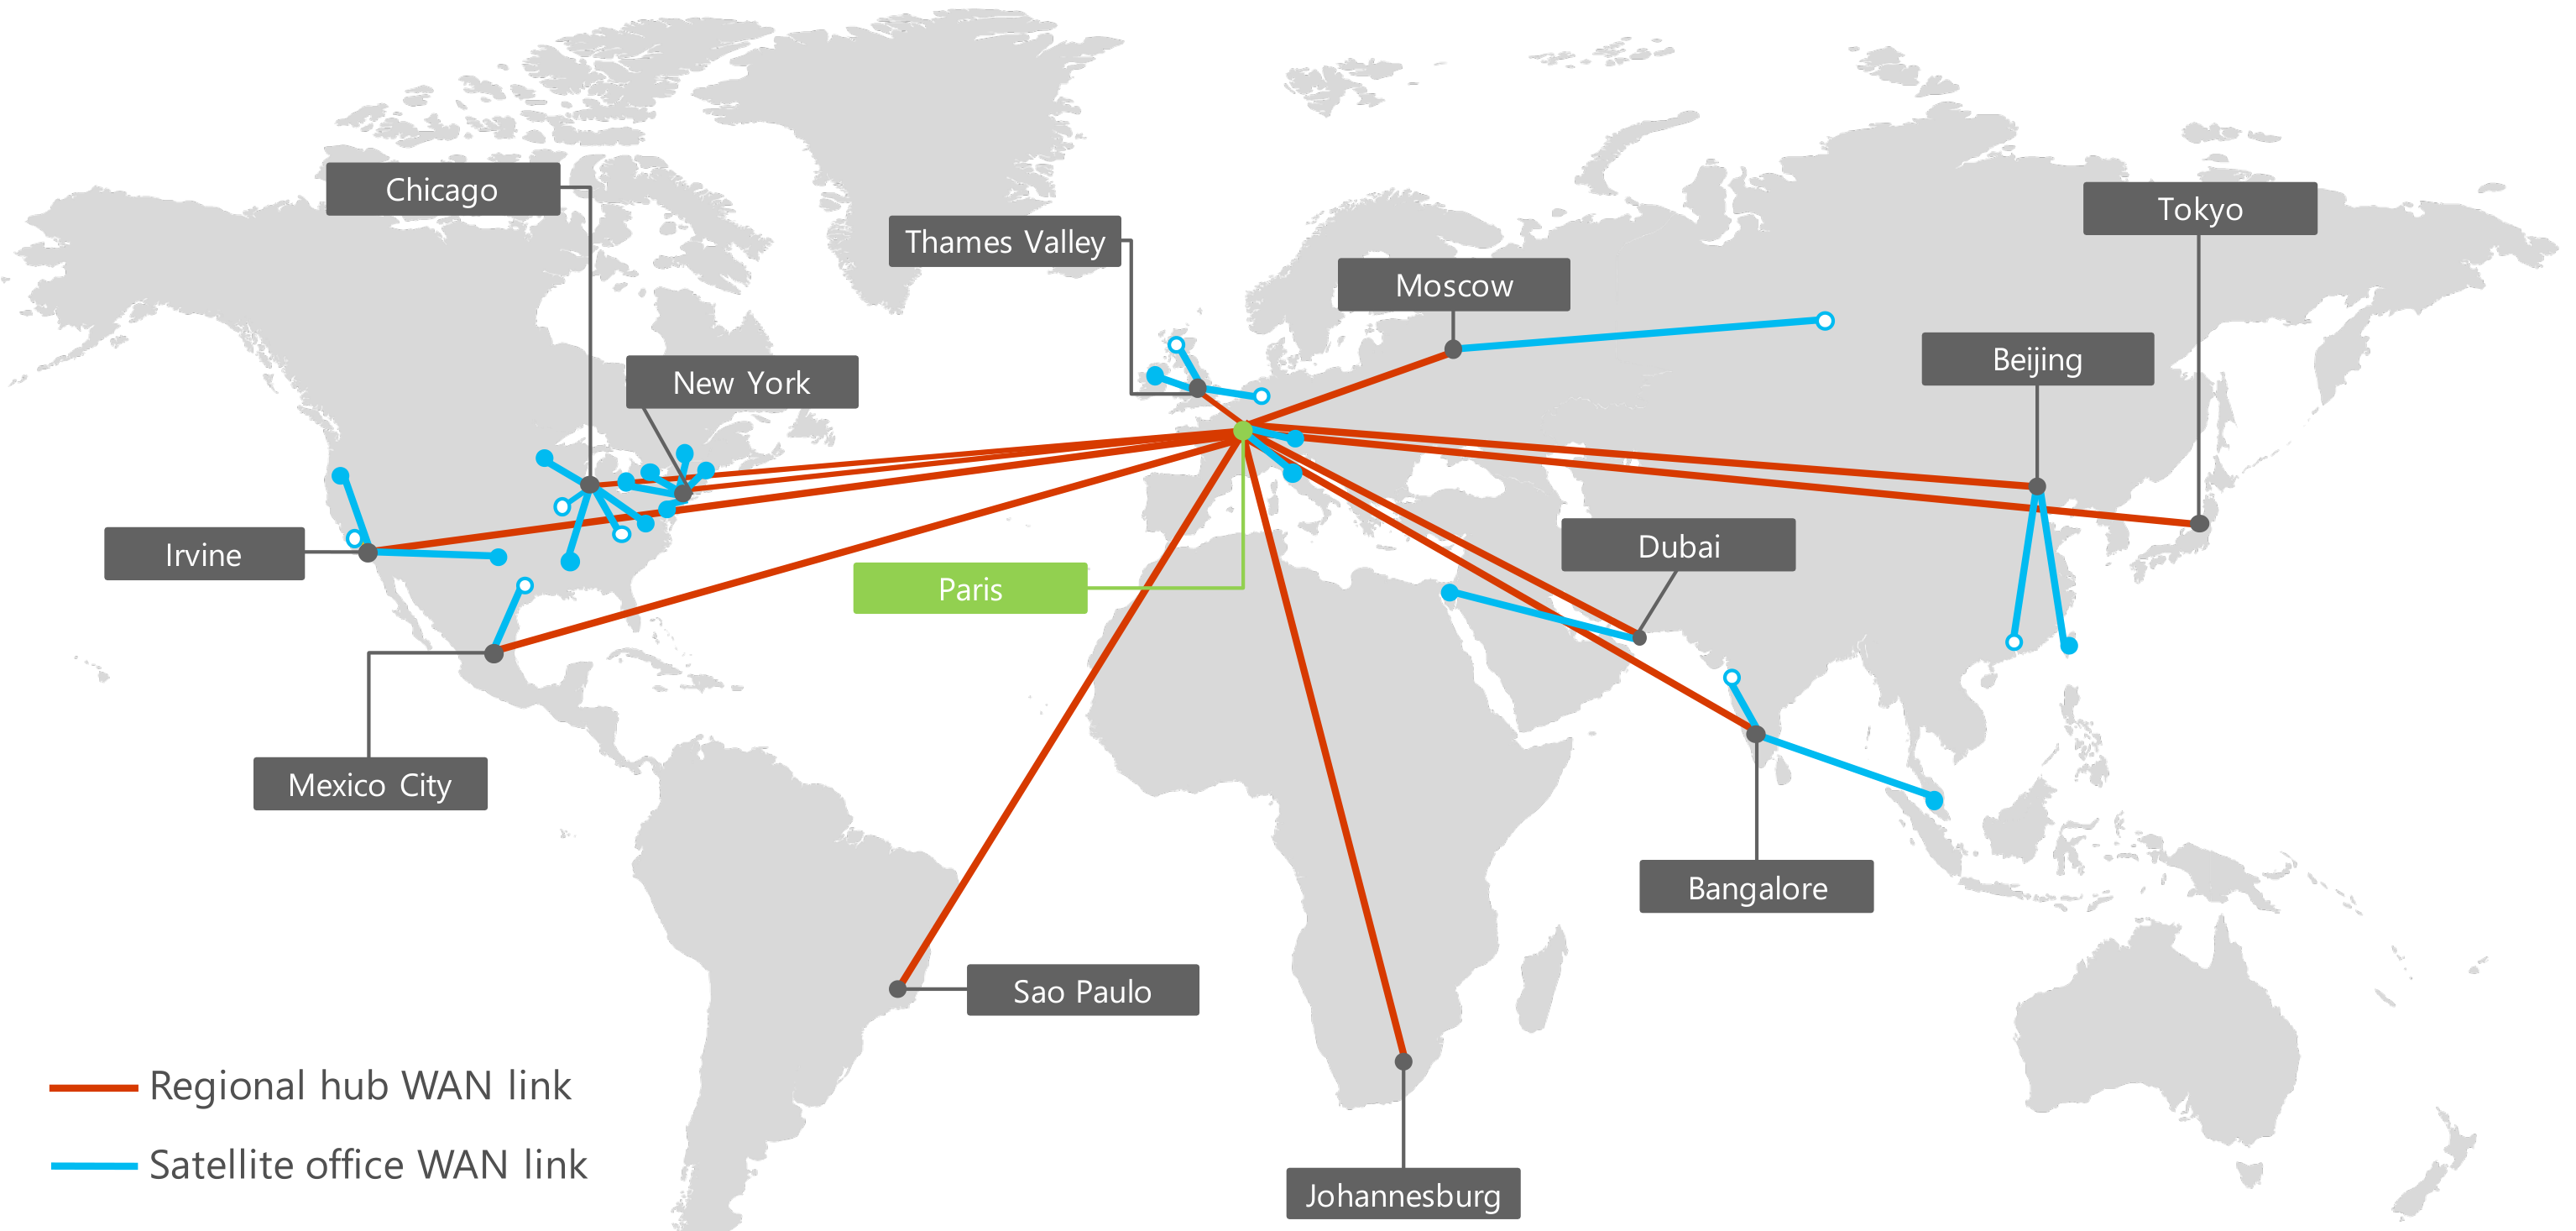


******************** Image 4: extracted_images/architecture_cropped_image_11.png ********************



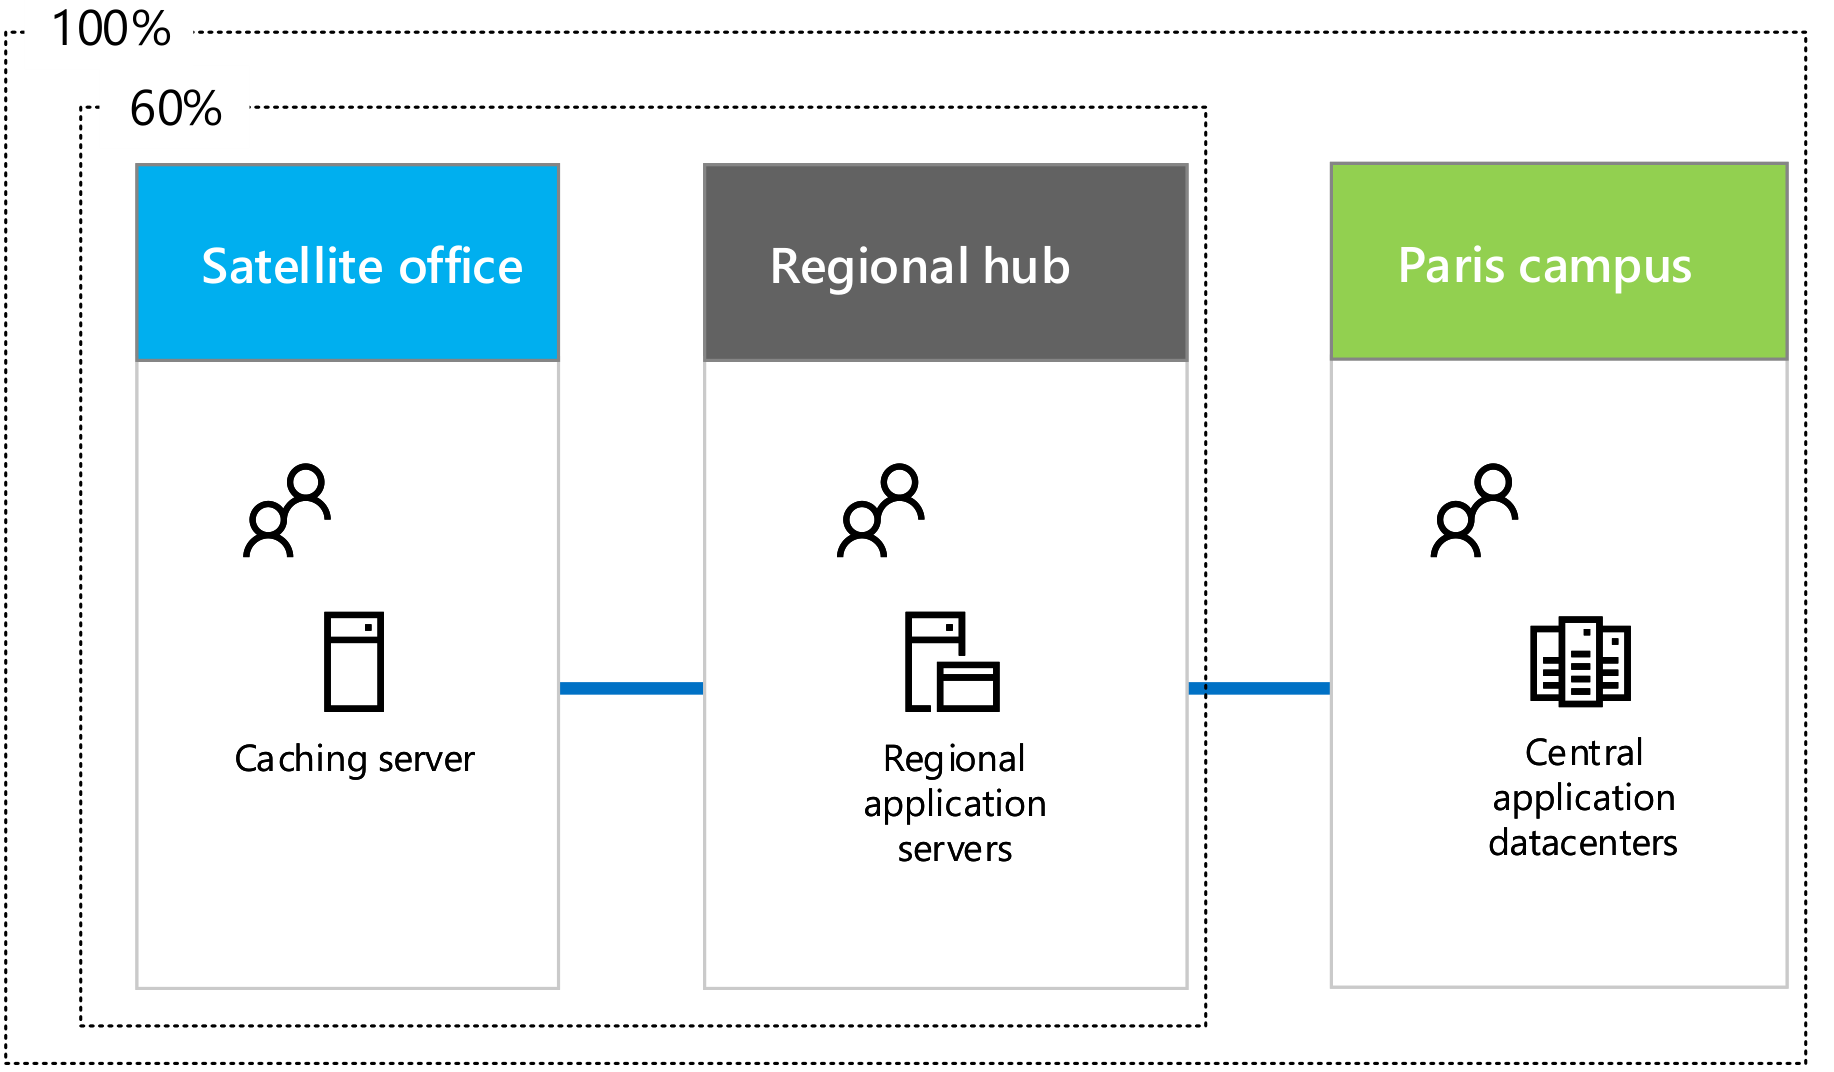


******************** Image 5: extracted_images/architecture_cropped_image_12.png ********************



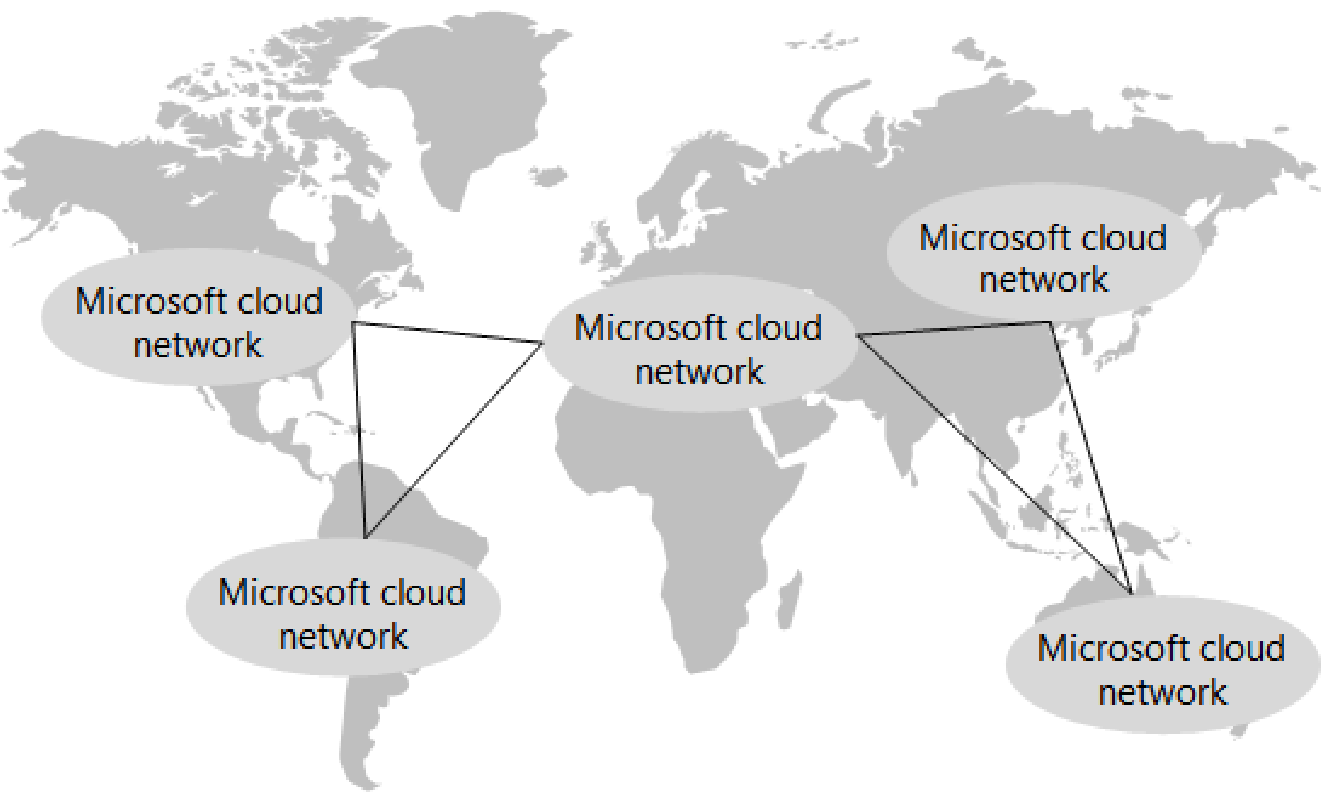


******************** Image 6: extracted_images/architecture_cropped_image_13.png ********************



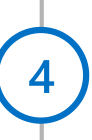


******************** Image 7: extracted_images/architecture_cropped_image_14.png ********************



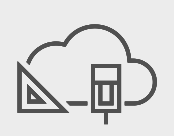


******************** Image 8: extracted_images/architecture_cropped_image_15.png ********************



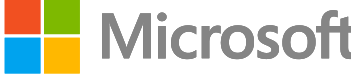


******************** Image 9: extracted_images/architecture_cropped_image_16.png ********************



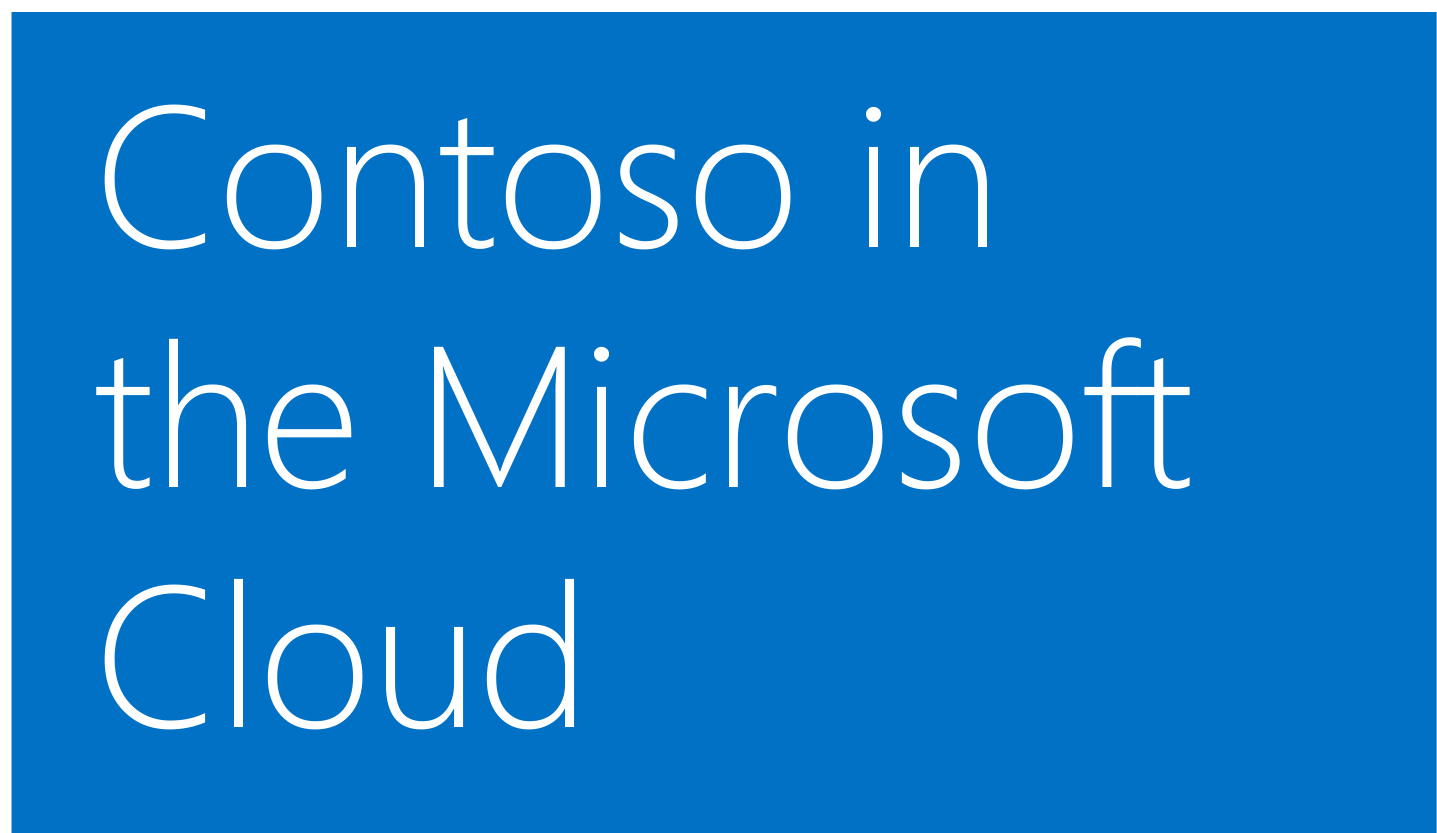


******************** Image 10: extracted_images/architecture_cropped_image_17.png ********************



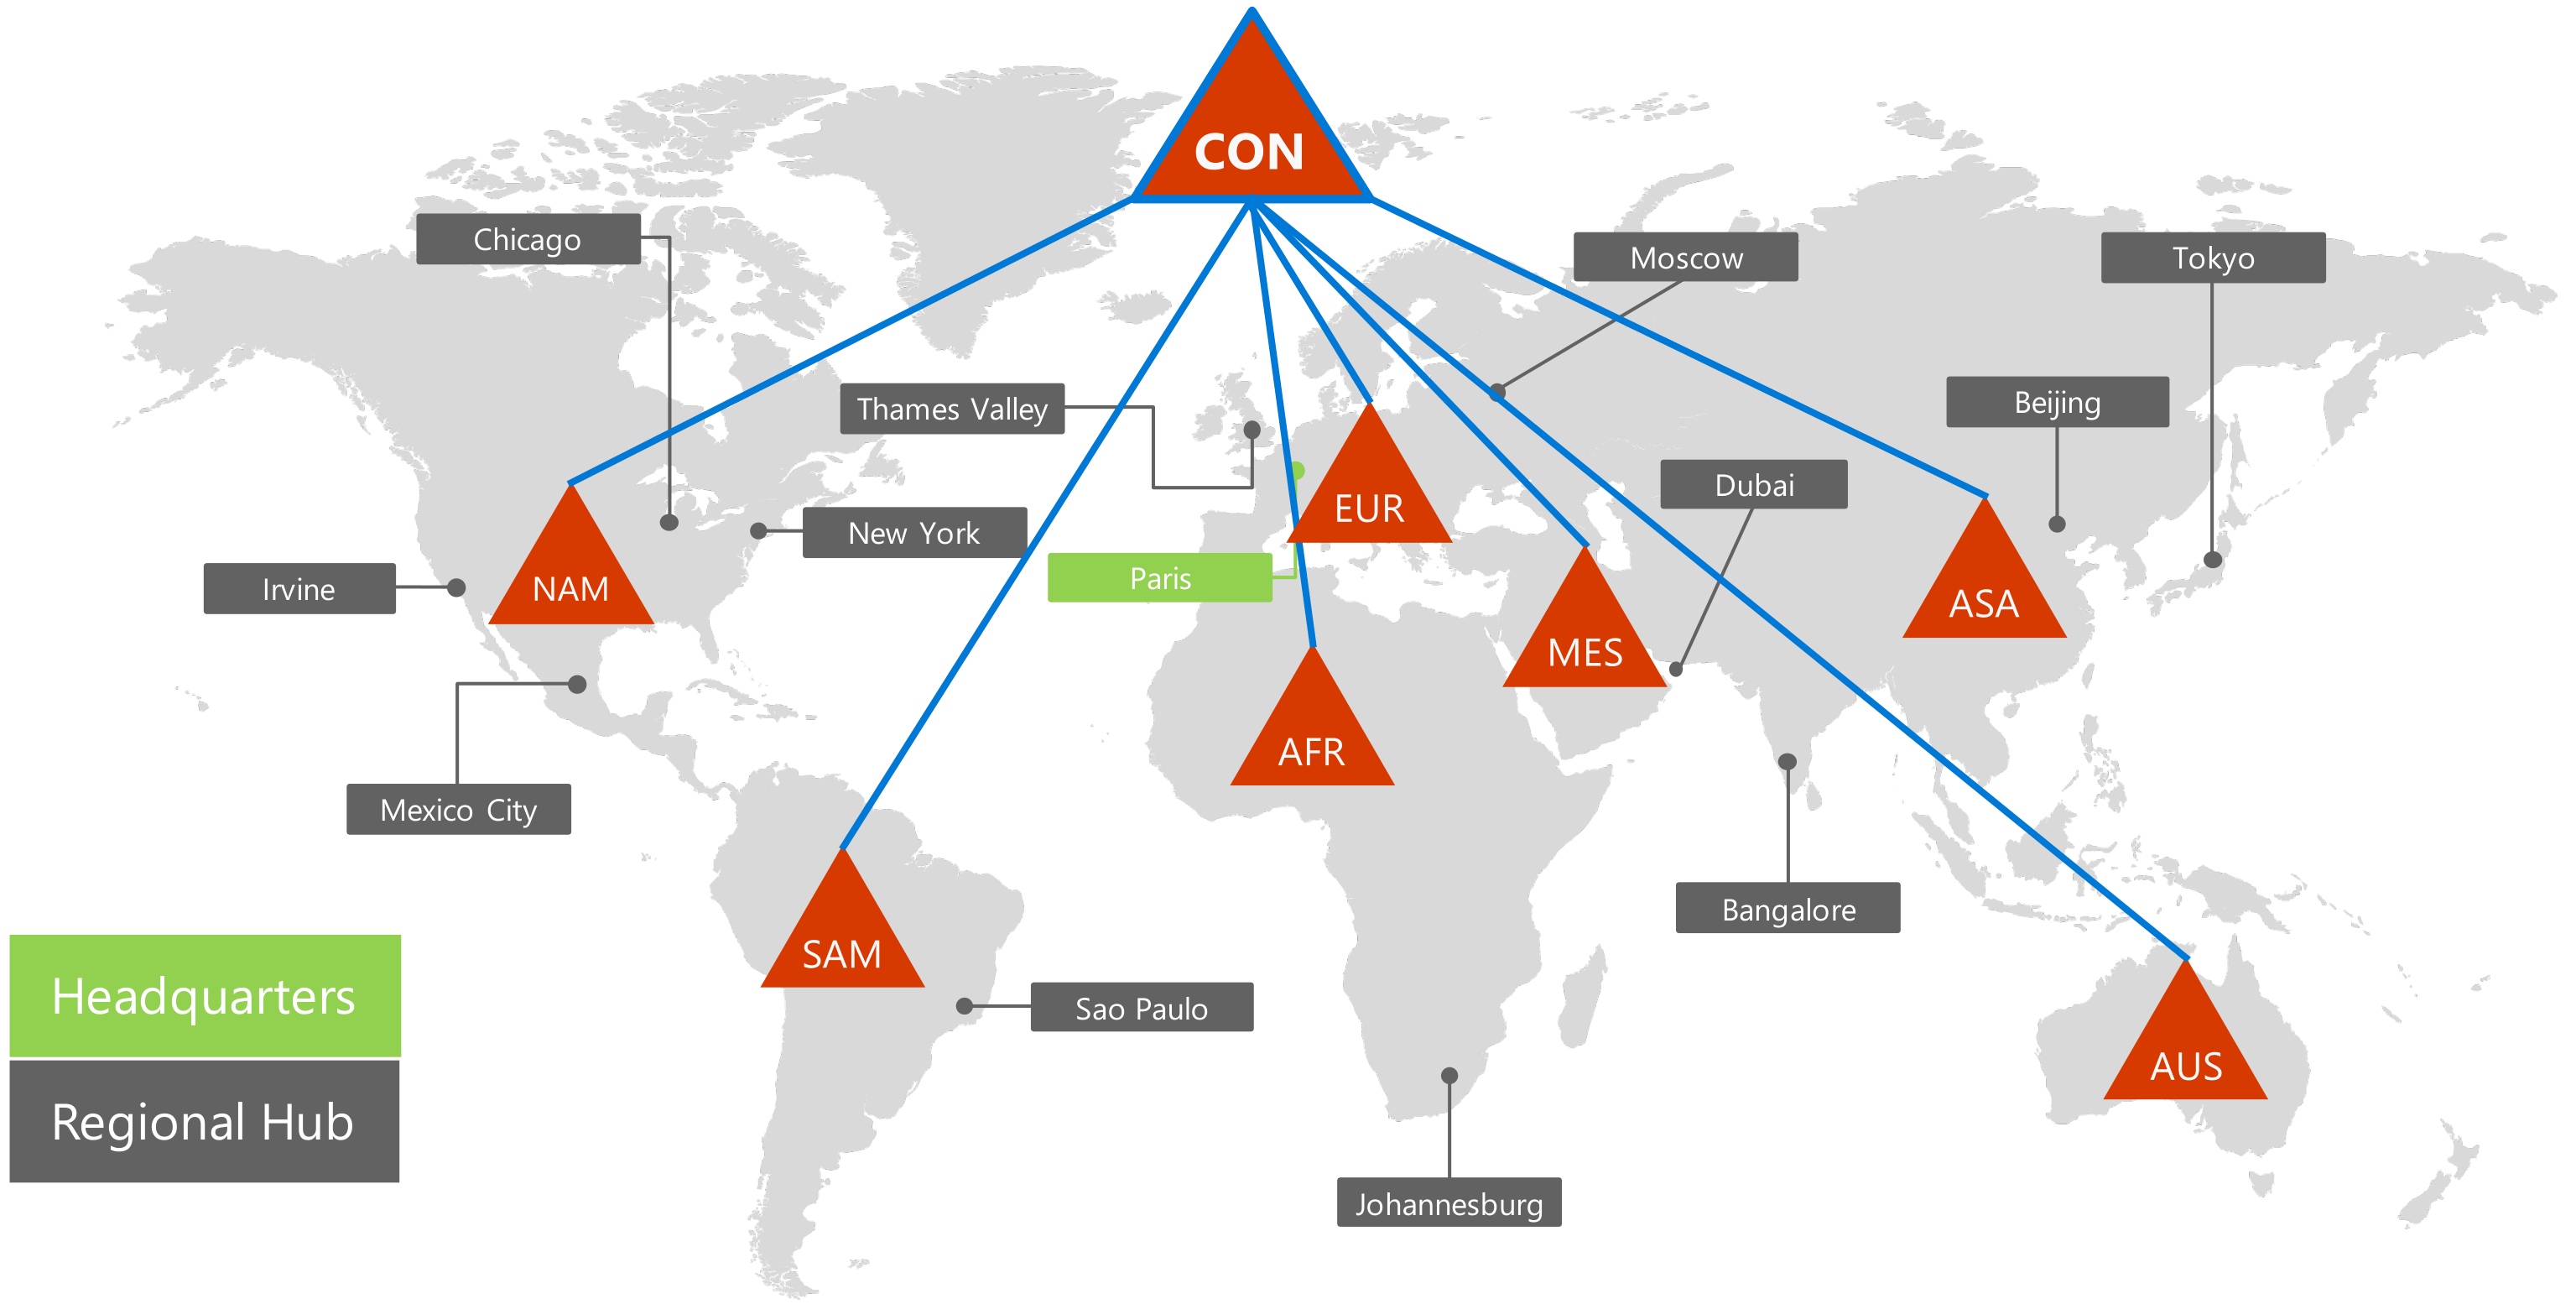


******************** Image 11: extracted_images/architecture_cropped_image_18.png ********************



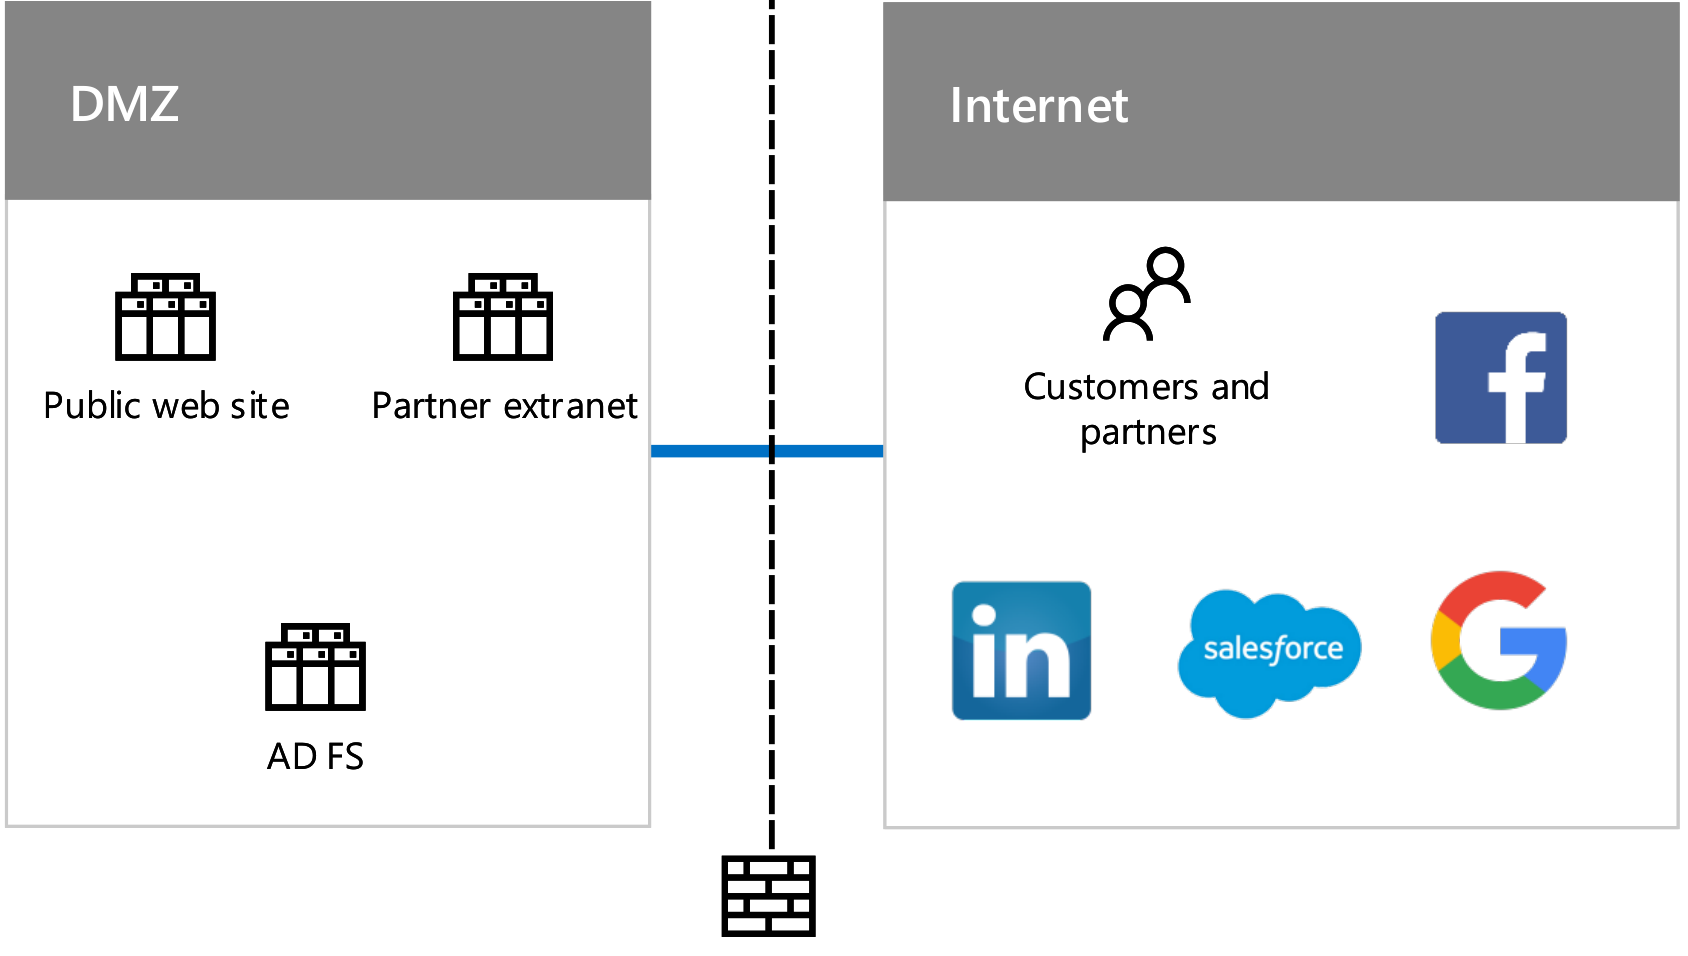


******************** Image 12: extracted_images/architecture_cropped_image_19.png ********************



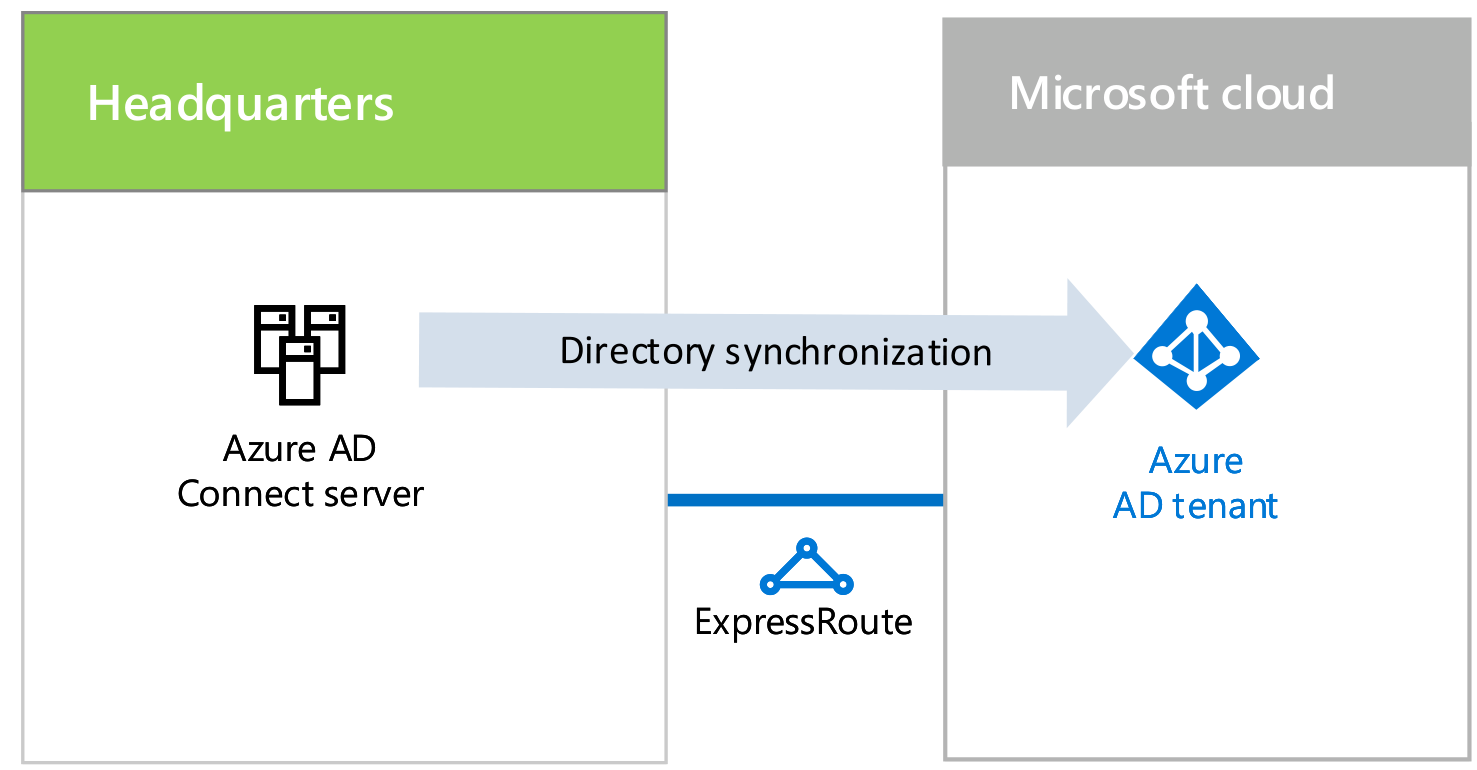


******************** Image 13: extracted_images/architecture_cropped_image_2.png ********************



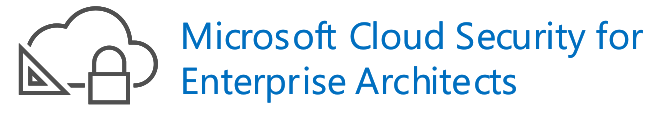


******************** Image 14: extracted_images/architecture_cropped_image_20.png ********************



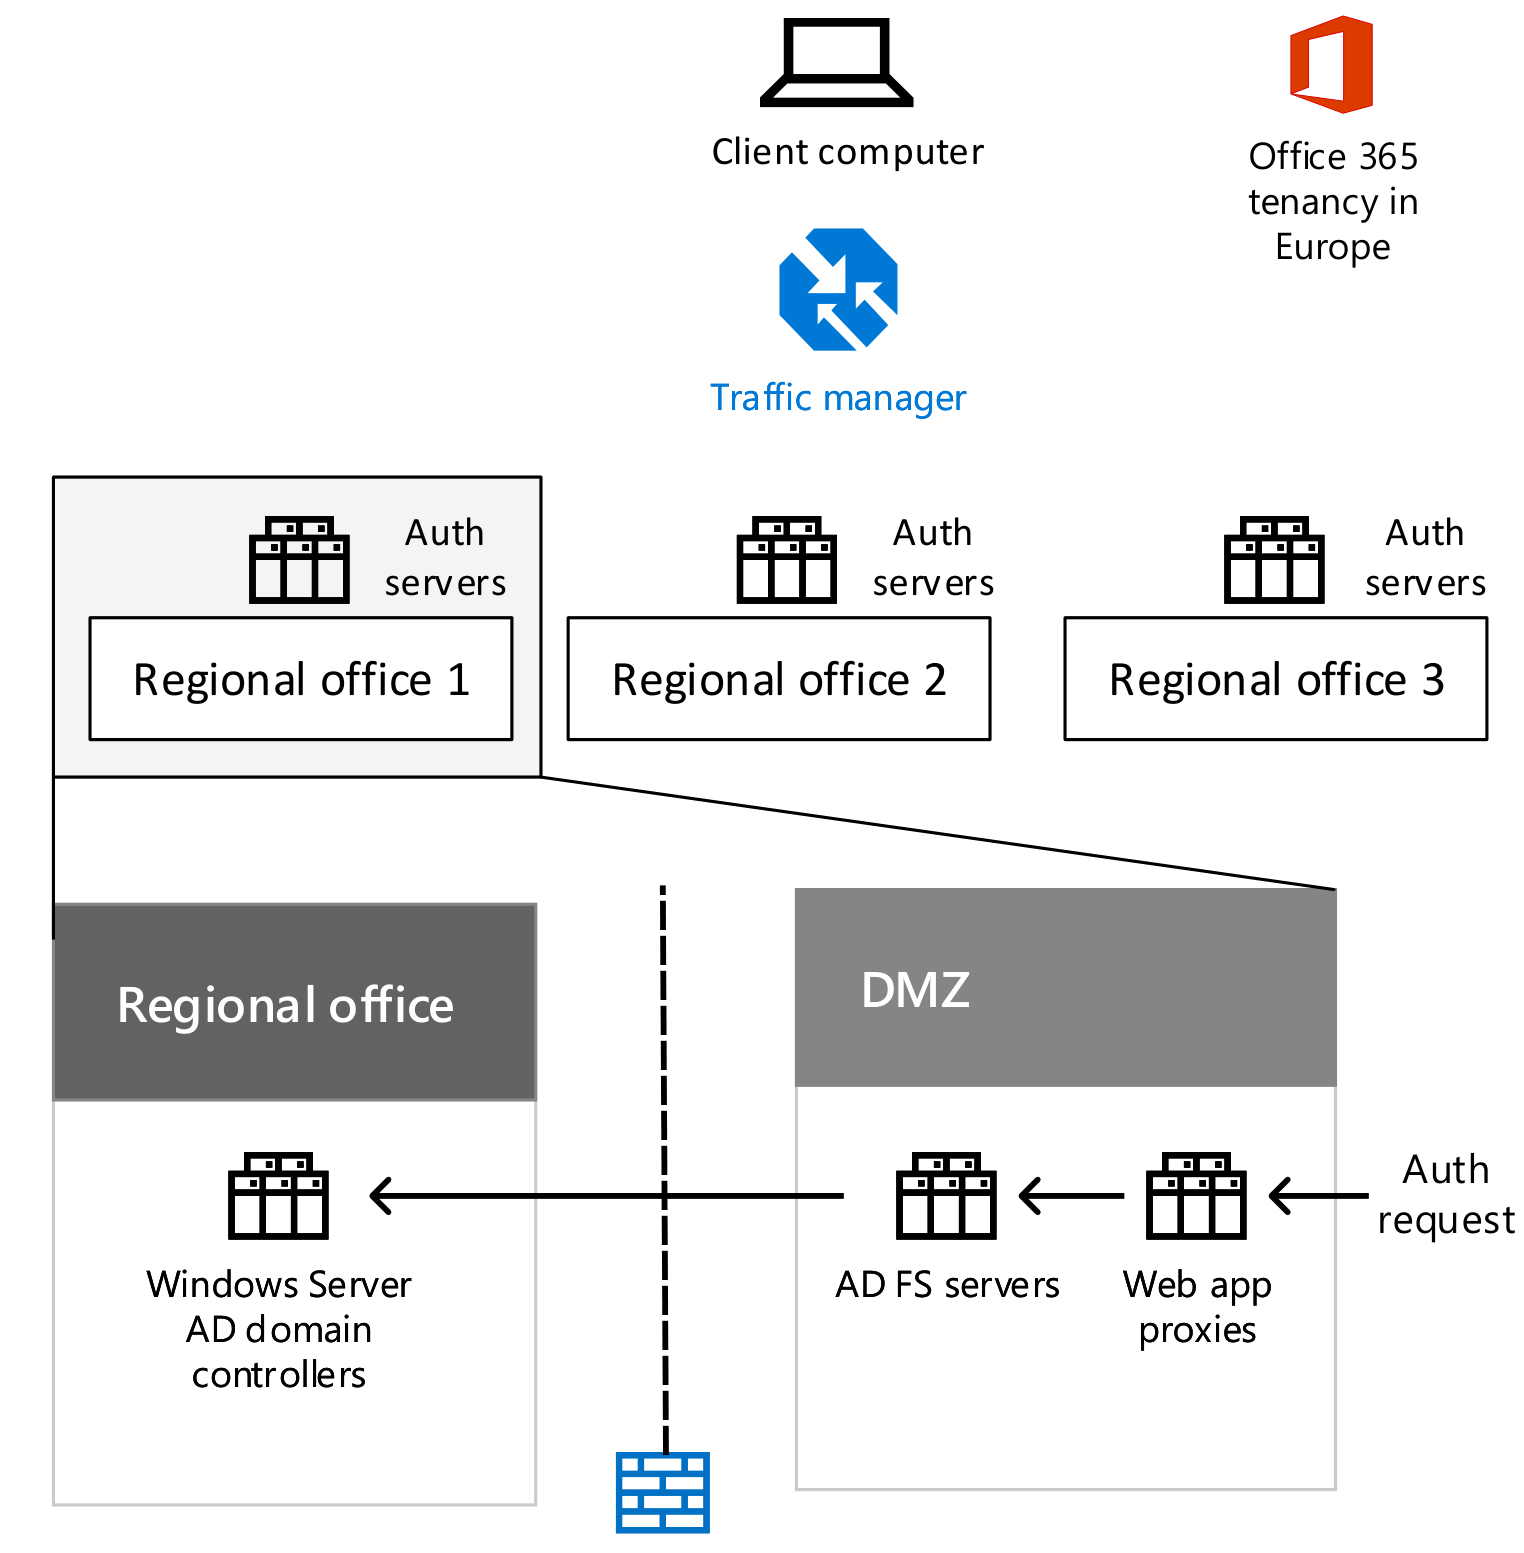


******************** Image 15: extracted_images/architecture_cropped_image_21.png ********************



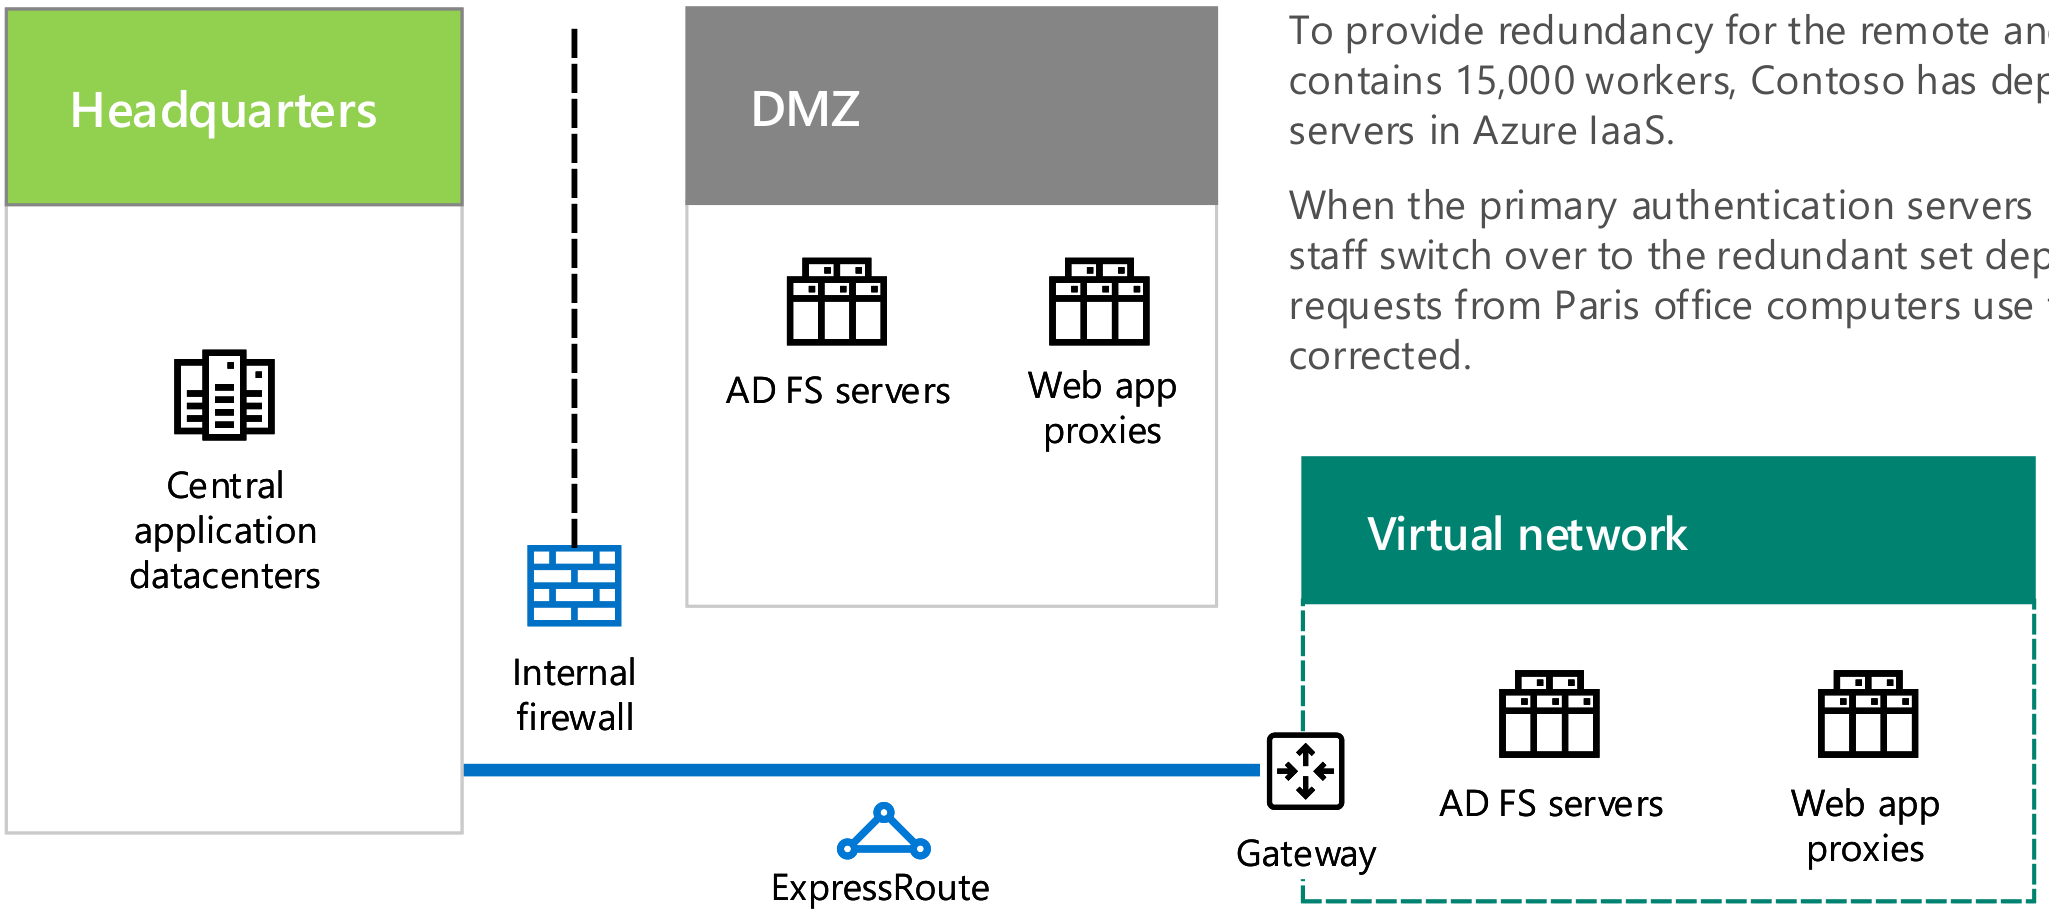


******************** Image 16: extracted_images/architecture_cropped_image_22.png ********************



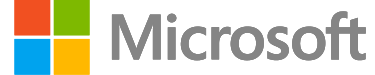


******************** Image 17: extracted_images/architecture_cropped_image_23.png ********************



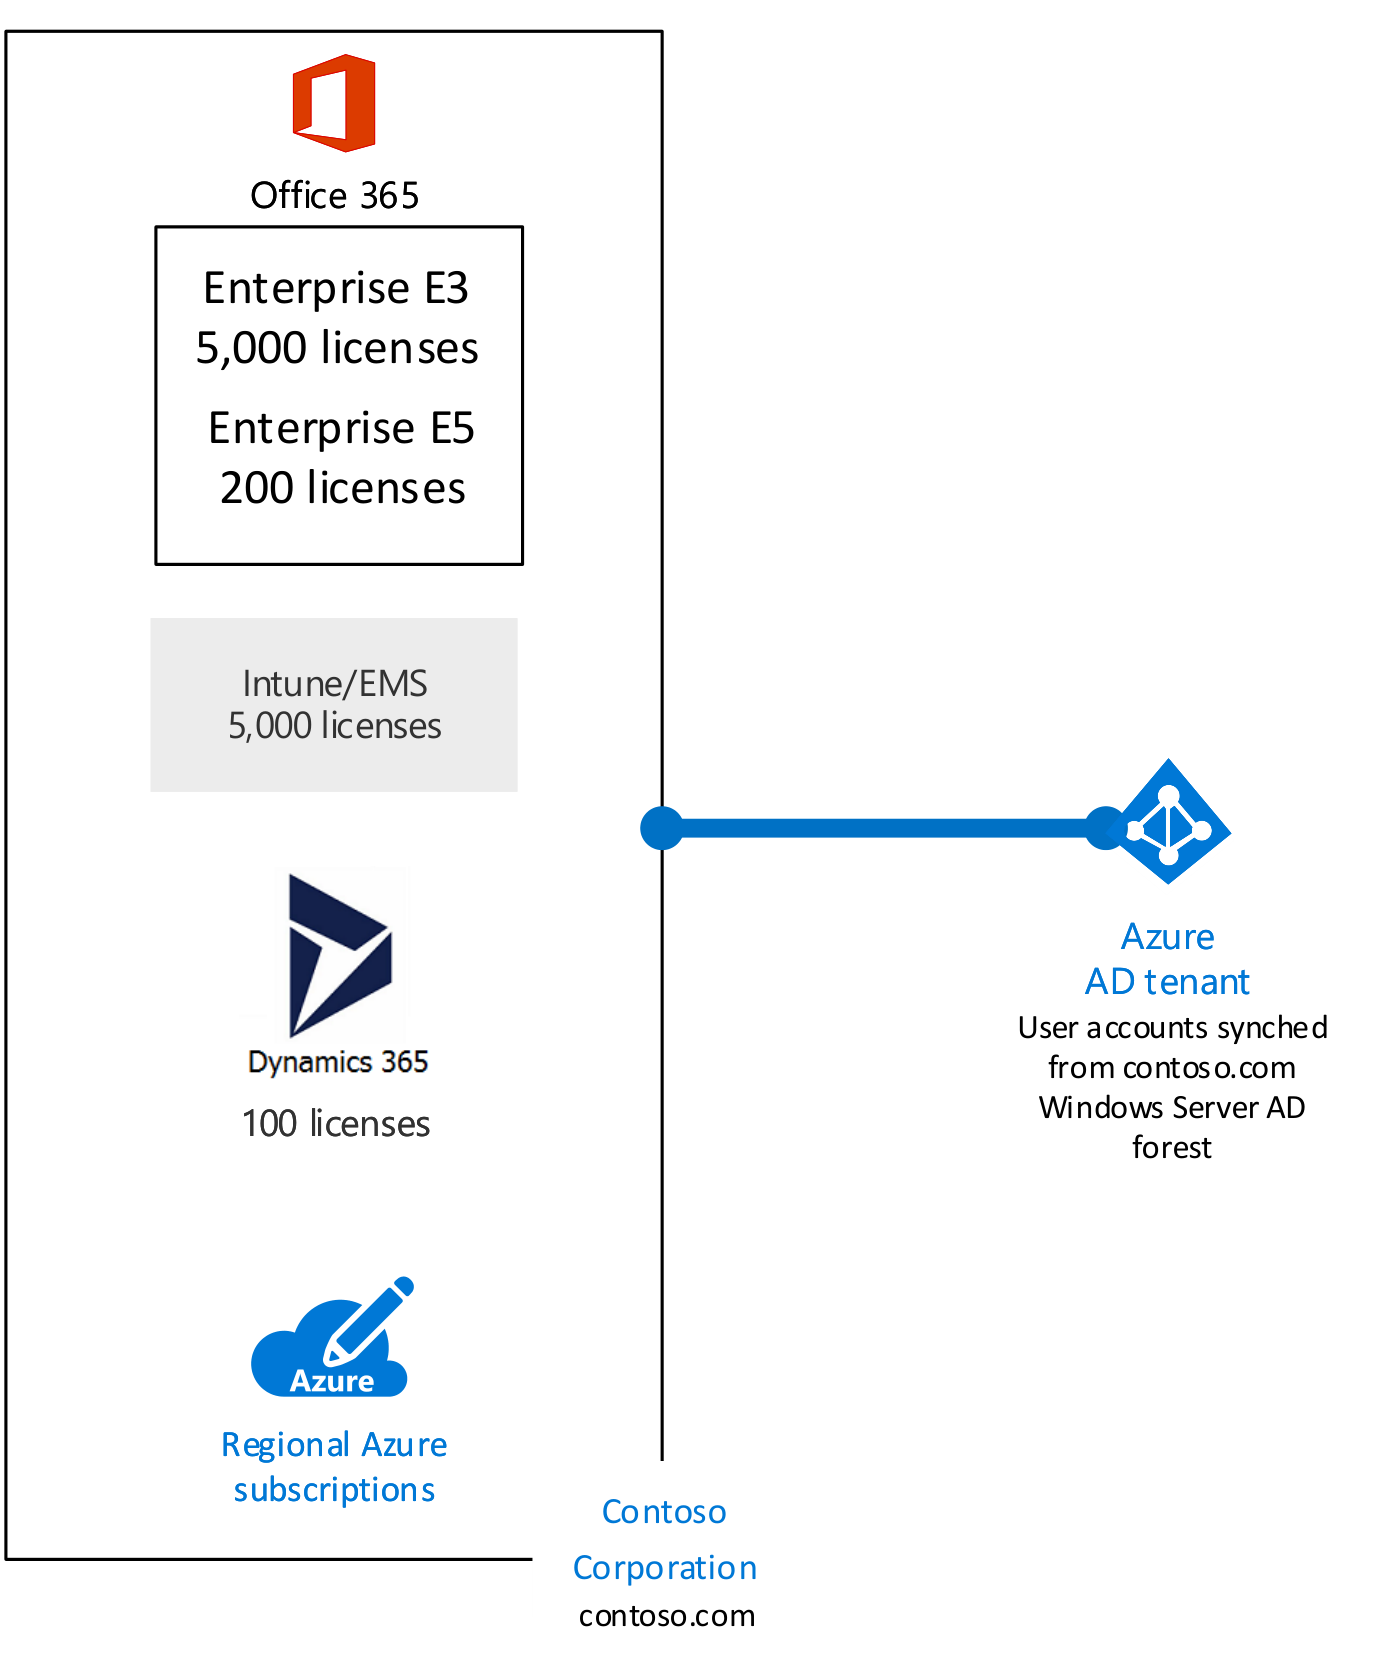


******************** Image 18: extracted_images/architecture_cropped_image_24.png ********************



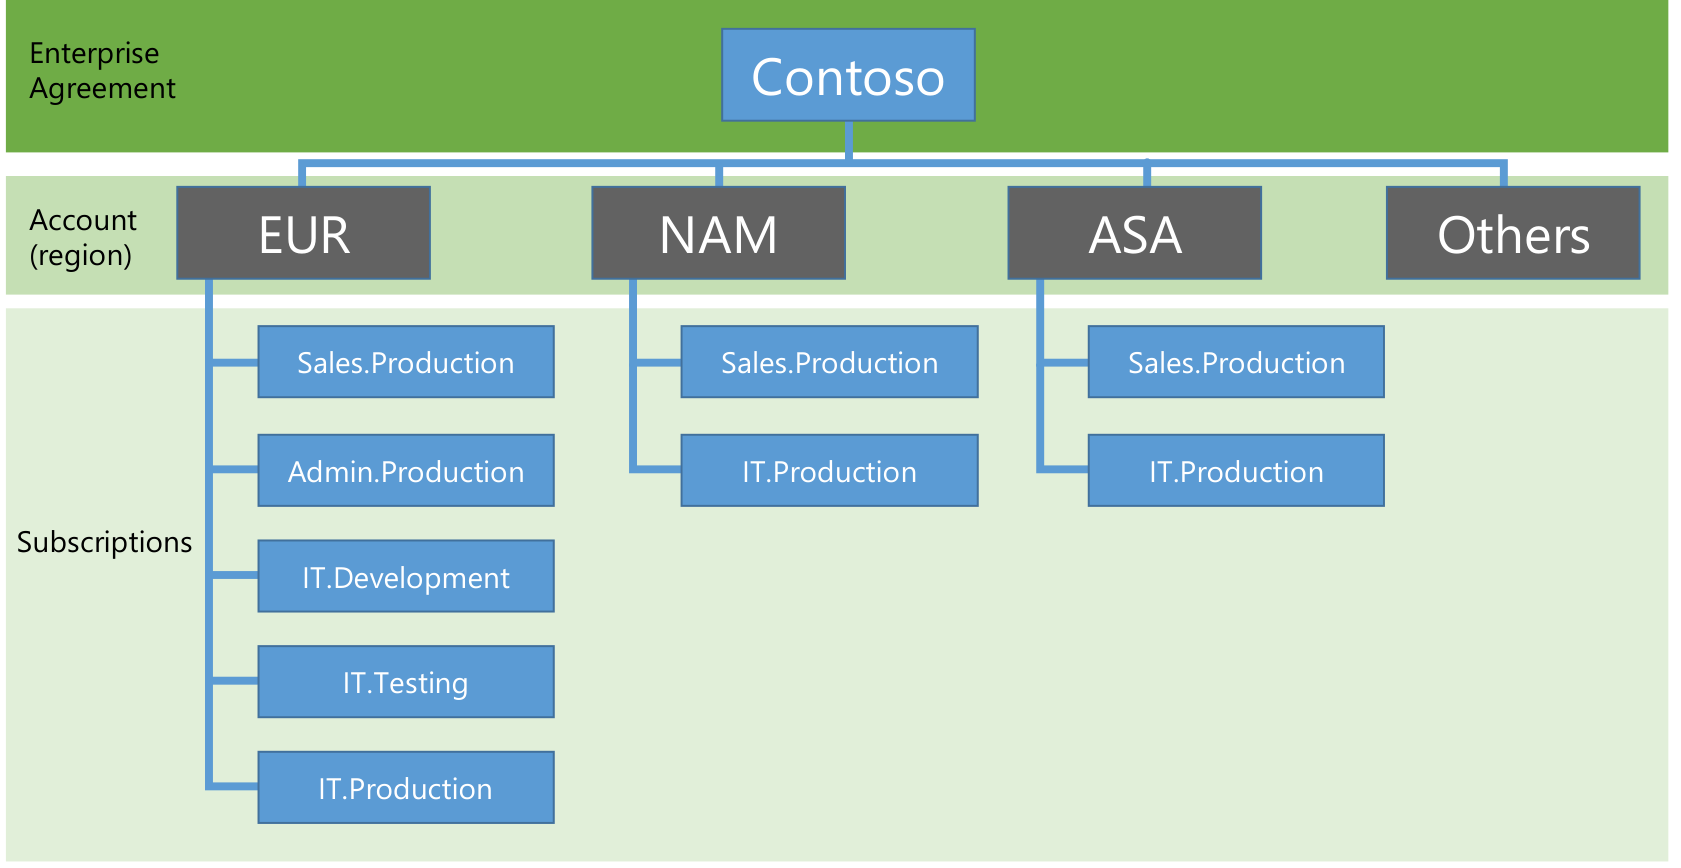


******************** Image 19: extracted_images/architecture_cropped_image_25.png ********************



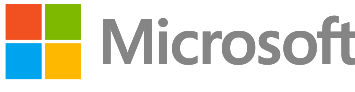


******************** Image 20: extracted_images/architecture_cropped_image_26.png ********************



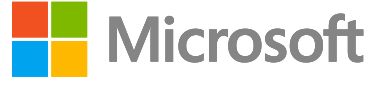


******************** Image 21: extracted_images/architecture_cropped_image_27.png ********************



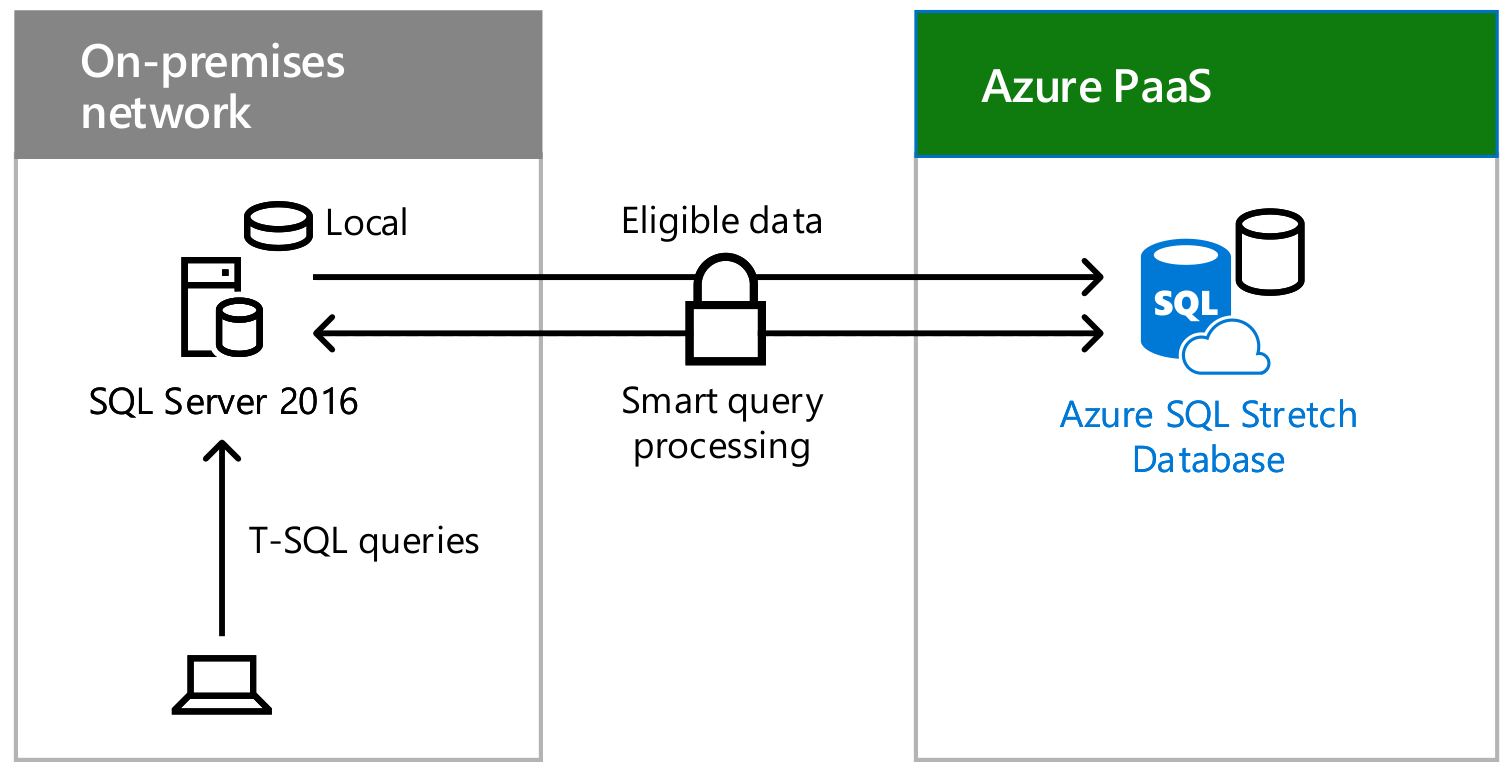


******************** Image 22: extracted_images/architecture_cropped_image_28.png ********************



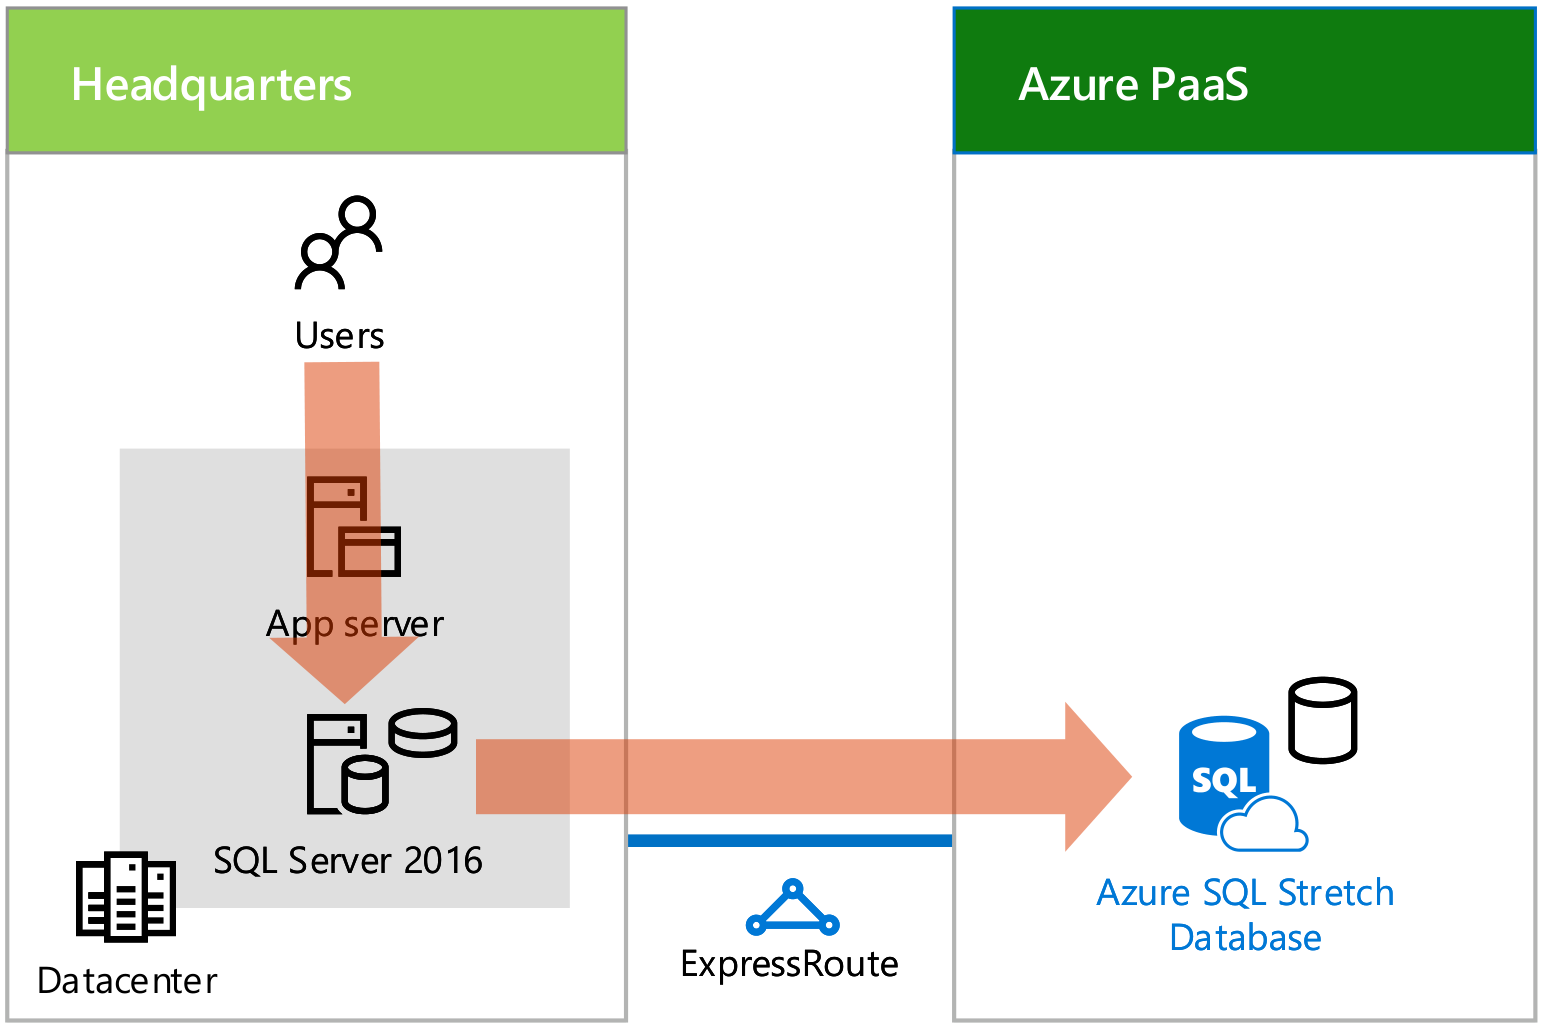


******************** Image 23: extracted_images/architecture_cropped_image_29.png ********************



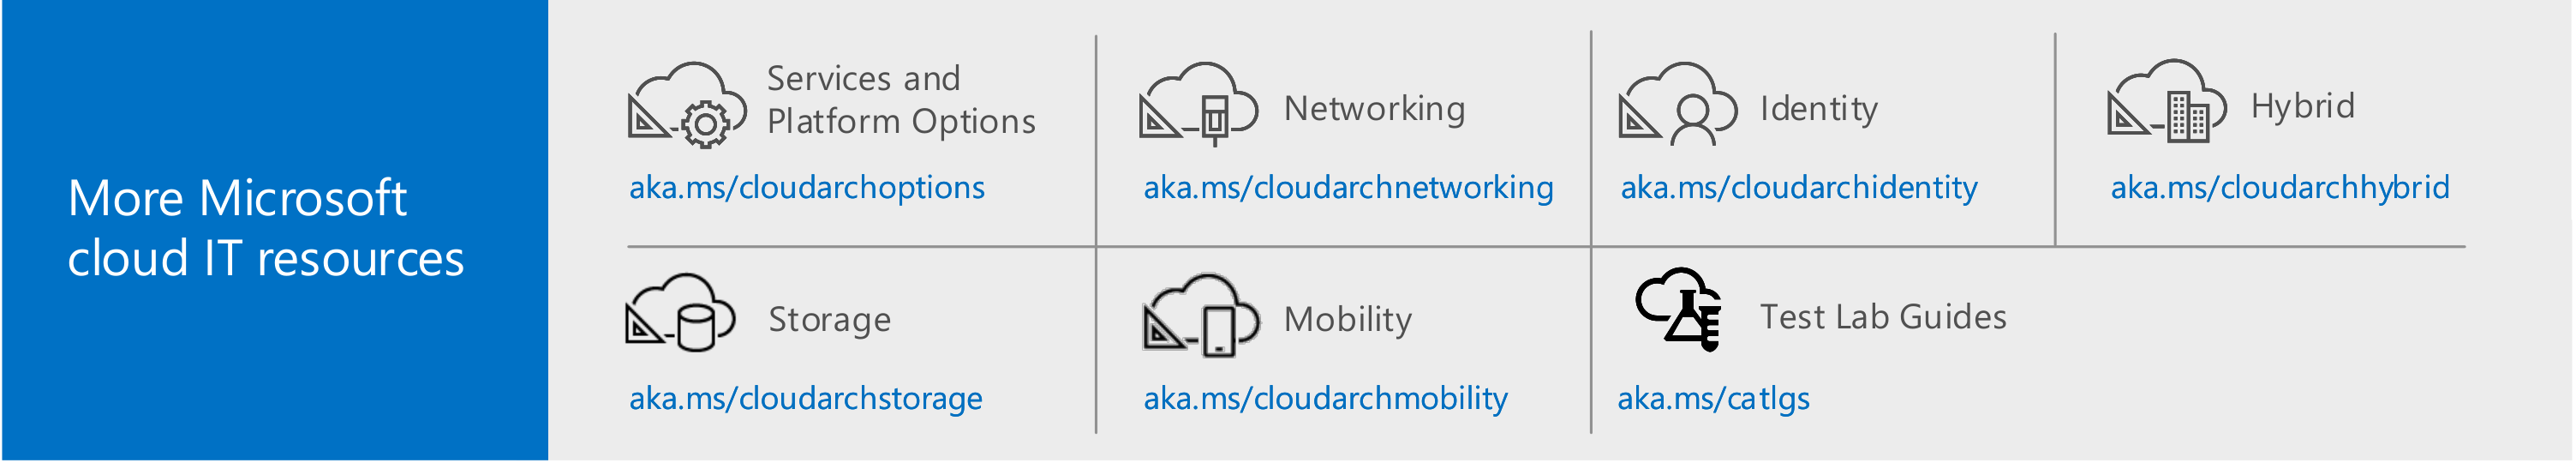


******************** Image 24: extracted_images/architecture_cropped_image_3.png ********************



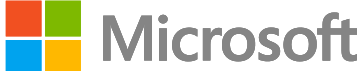


******************** Image 25: extracted_images/architecture_cropped_image_4.png ********************



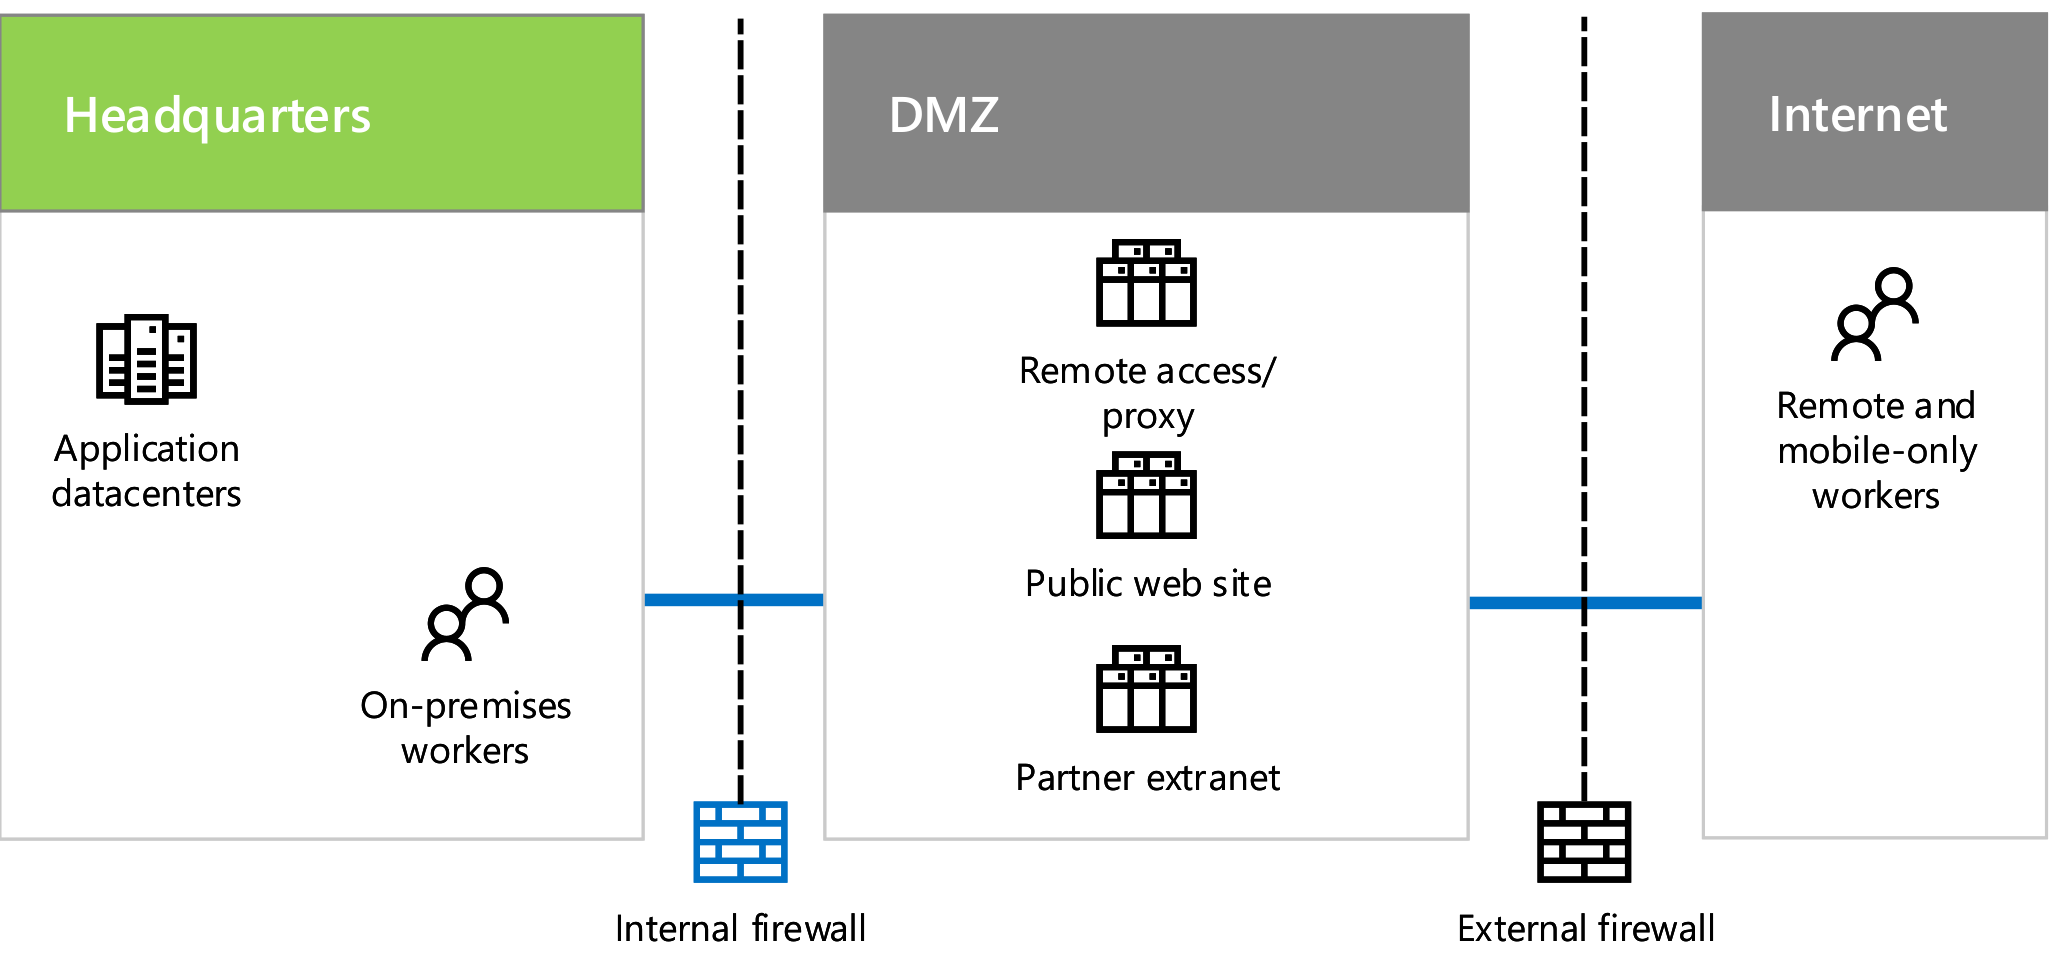


******************** Image 26: extracted_images/architecture_cropped_image_5.png ********************



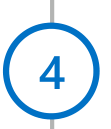


******************** Image 27: extracted_images/architecture_cropped_image_6.png ********************



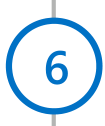


******************** Image 28: extracted_images/architecture_cropped_image_7.png ********************



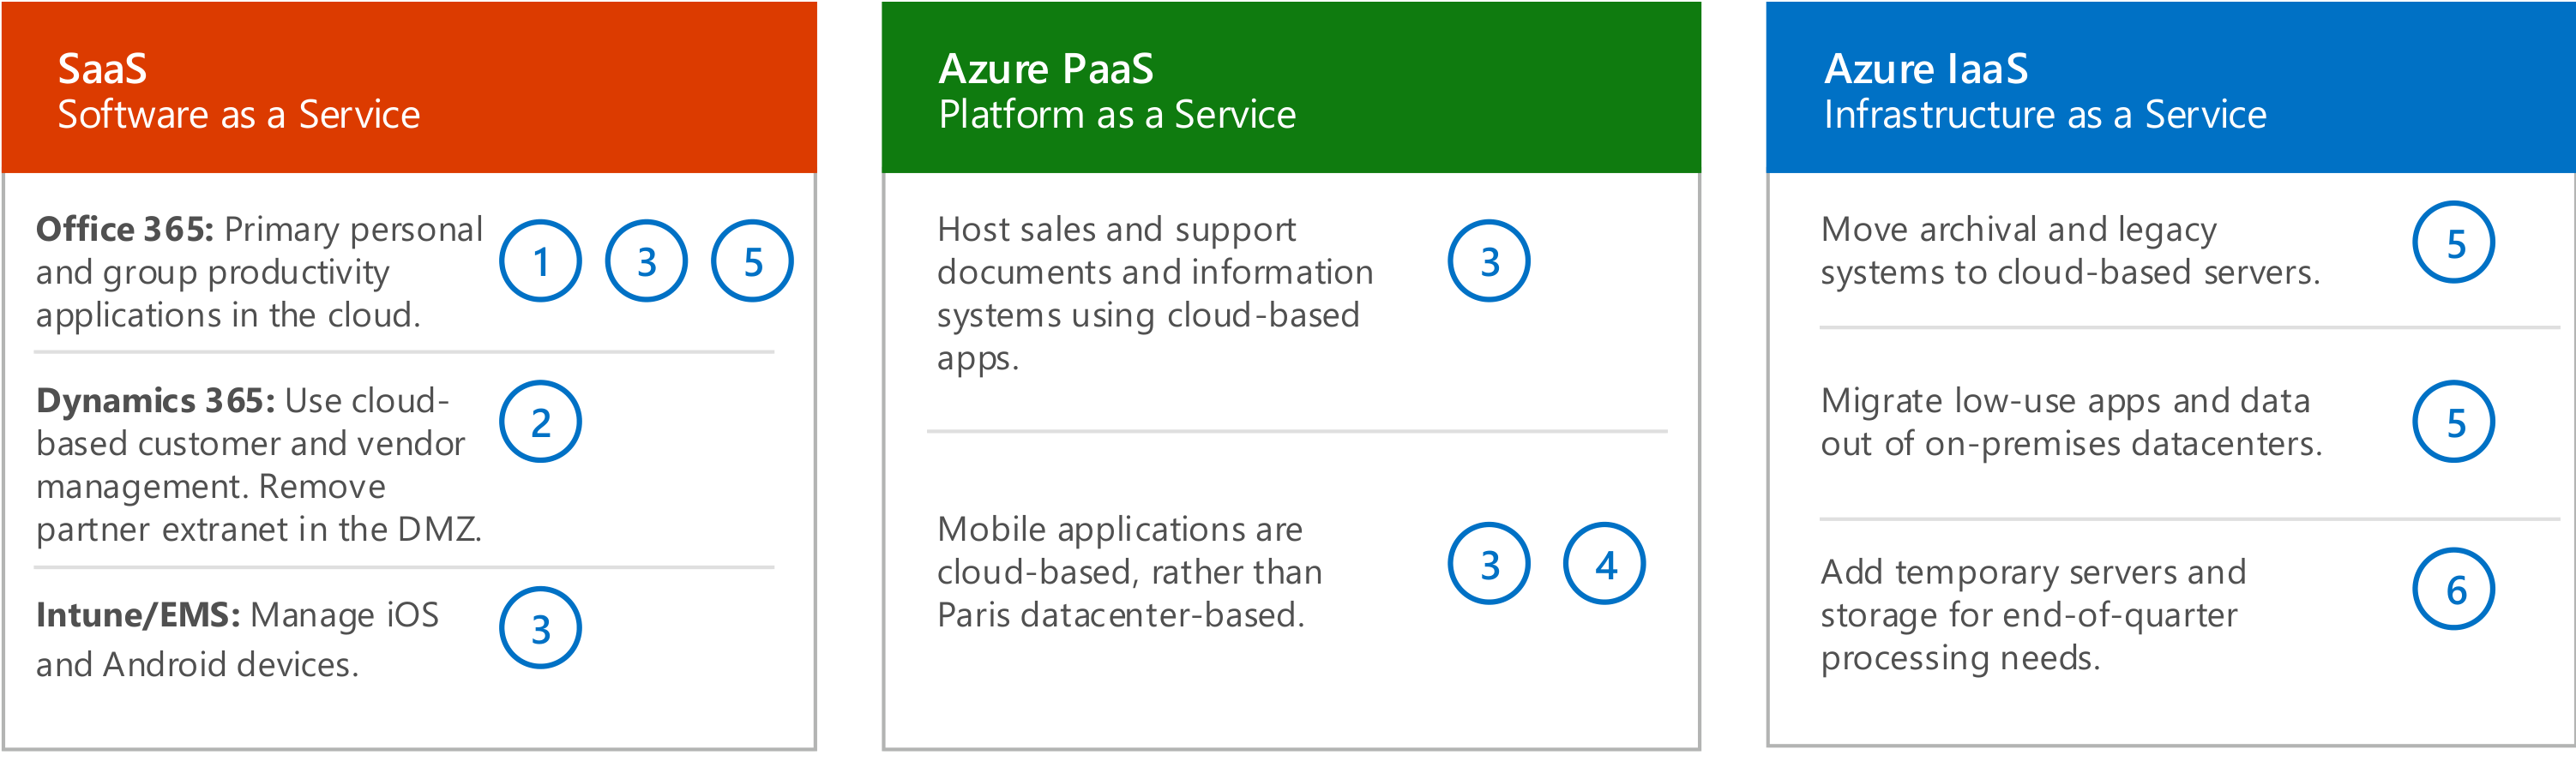


******************** Image 29: extracted_images/architecture_cropped_image_8.png ********************



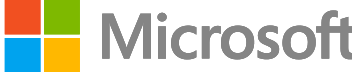


******************** Image 30: extracted_images/architecture_cropped_image_9.png ********************



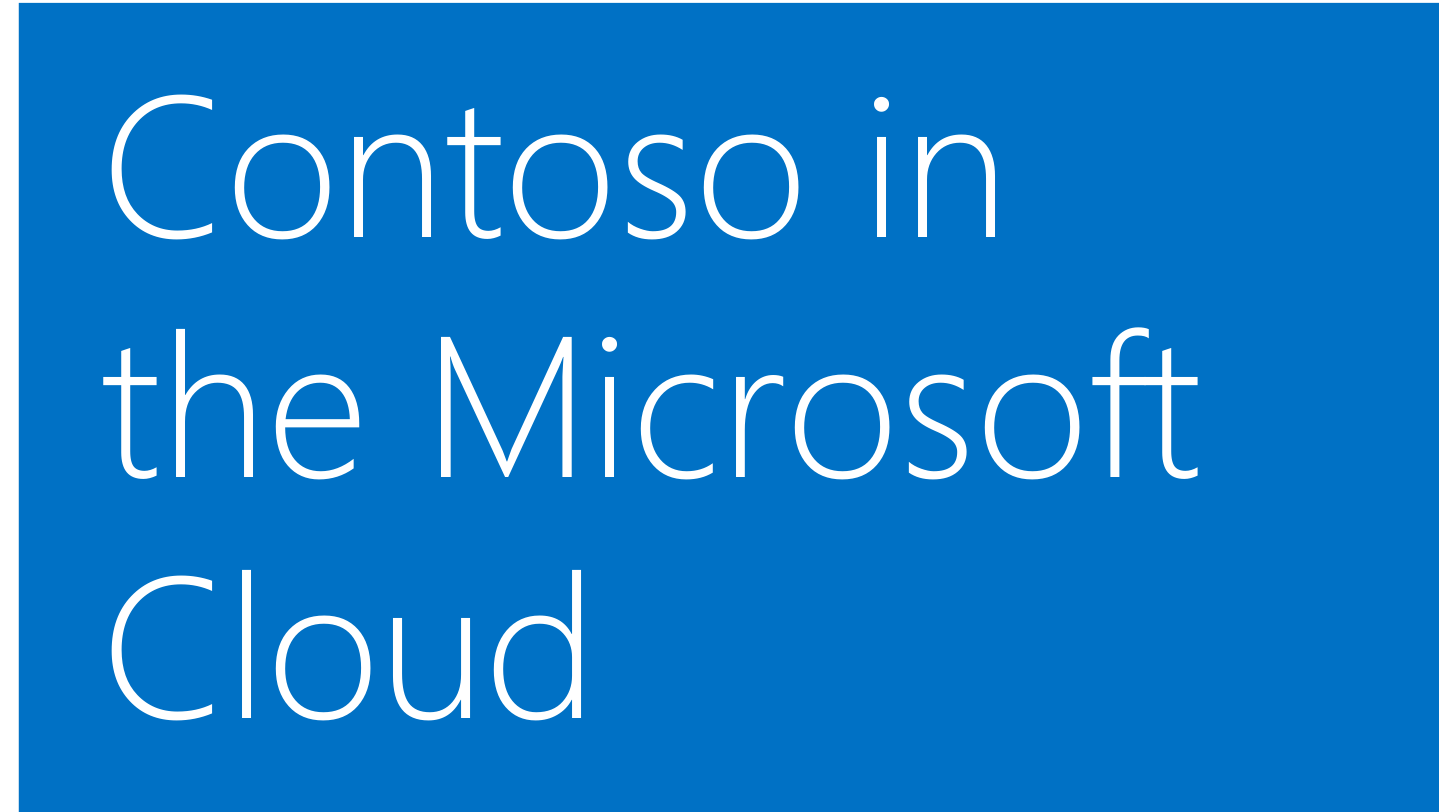

In [34]:
basename = os.path.basename(doc_file)
name, extension = os.path.splitext(basename)

images_list = []

for filename in os.listdir(OUTPUT_DIR):
    if filename.startswith(name):
        full_path = os.path.join(OUTPUT_DIR, filename)
        if os.path.isfile(full_path):
            images_list.append(full_path)

print(f"Extracted images from {doc_file}")

for idx in range(len(images_list)):
    print("\033[1;31;32m")
    print(f"******************** Image {idx+1}: {images_list[idx]} ********************\n")
    display(Image.open(images_list[idx]))